Importation of the python packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Importation of the deep emotions module.

In [2]:
from deepemotions.preprocess import preprocessing
from deepemotions.questionnaire_utils import read_quest
from deepemotions.utils import resampling_labels, accuracy, init_membership
from deepemotions.deepcluster import DeepCMeams, DeepKMeans
from deepemotions.cluster import KMeans, CMeans

The path do the WESAD data set

In [3]:
path = r"data/WESAD/"

The constant variables

In [4]:
subjects = ["S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S13", "S14", "S15", "S16", "S17"]
SEQ_LEN = 20
INIT_TIME = 0
NB_CLASSES = 4
LABEL_RATE = 700 #hz
CARDIO_SAMPLING_RATE = 64 #hz


Random assigniment

In [5]:
results_rd = {}
for i in range(NB_CLASSES):
	results_rd["class " + str(i)] = []
results_rd["accuracy"] = []

phases_list = ["A", "D", "B", "C"]

for s in subjects:
    print("\n subject:", s)

    # physiological signals
    data = pd.read_pickle(path + s +"/"+ s +".pkl")
    labels_true = data["label"]

    # peuso-label assignment
    labels_hat = np.tile(range(1, NB_CLASSES +1), reps=int(labels_true.size/4))
    labels_hat = labels_hat[:labels_true.size]

    list_acc, over_all_accuracy = accuracy(labels_true=labels_true, labels_hat=labels_hat, classes=list(range(1, NB_CLASSES+1)))
    for i in range(NB_CLASSES):
        results_rd["class " + str(i)].append(list_acc[i])
    results_rd["accuracy"].append(over_all_accuracy)
    print(list_acc, over_all_accuracy)


 subject: S2
[0.3064969778060913, 0.22994951903820038, 0.16693589091300964, 0.2576751410961151] 0.25000012362168006

 subject: S3
[0.3042027950286865, 0.23293879628181458, 0.16910935938358307, 0.2576380670070648] 0.24999987831595116

 subject: S4
[0.304656445980072, 0.23048977553844452, 0.1668909788131714, 0.260096937417984] 0.2499998797499376

 subject: S5
[0.3070613741874695, 0.23072795569896698, 0.1659640520811081, 0.25666719675064087] 0.25

 subject: S6
[0.3061356842517853, 0.23259975016117096, 0.1661827117204666, 0.25647711753845215] 0.25

 subject: S7
[0.3067770302295685, 0.23071329295635223, 0.16621962189674377, 0.2569939196109772] 0.2499997609487847

 subject: S8
[0.3043874502182007, 0.23570799827575684, 0.16499464213848114, 0.25723081827163696] 0.250000118849593

 subject: S9
[0.30609598755836487, 0.23159784078598022, 0.16614560782909393, 0.25738397240638733] 0.25

 subject: S10
[0.3028358817100525, 0.2427590787410736, 0.16312211751937866, 0.2544350326061249] 0.25

 subject: 

In [6]:
results_rd = pd.DataFrame(results_rd, index=subjects)
print(results_rd)
print(results_rd.describe().round(2))

      class 0   class 1   class 2   class 3  accuracy
S2   0.306497  0.229950  0.166936  0.257675      0.25
S3   0.304203  0.232939  0.169109  0.257638      0.25
S4   0.304656  0.230490  0.166891  0.260097      0.25
S5   0.307061  0.230728  0.165964  0.256667      0.25
S6   0.306136  0.232600  0.166183  0.256477      0.25
S7   0.306777  0.230713  0.166220  0.256994      0.25
S8   0.304387  0.235708  0.164995  0.257231      0.25
S9   0.306096  0.231598  0.166146  0.257384      0.25
S10  0.302836  0.242759  0.163122  0.254435      0.25
S11  0.304949  0.236975  0.163883  0.255863      0.25
S13  0.304870  0.233926  0.167949  0.256410      0.25
S14  0.304870  0.235973  0.165003  0.256253      0.25
S15  0.304129  0.237740  0.164784  0.256005      0.25
S16  0.305186  0.235933  0.164103  0.256269      0.25
S17  0.305523  0.245126  0.165517  0.246501      0.25
       class 0  class 1  class 2  class 3  accuracy
count    15.00    15.00    15.00    15.00     15.00
mean      0.31     0.23     0.17

In [7]:
print(results_rd.describe())

         class 0    class 1    class 2    class 3      accuracy
count  15.000000  15.000000  15.000000  15.000000  1.500000e+01
mean    0.305212   0.234877   0.165787   0.256127  2.500000e-01
std     0.001146   0.004484   0.001573   0.002929  1.032377e-07
min     0.302836   0.229950   0.163122   0.246501  2.499998e-01
25%     0.304522   0.231163   0.164889   0.256129  2.499999e-01
50%     0.304949   0.233926   0.165964   0.256477  2.500000e-01
75%     0.306116   0.236474   0.166555   0.257307  2.500000e-01
max     0.307061   0.245126   0.169109   0.260097  2.500001e-01


Questionnaire pre-processing

Computation of the average valence and arousal during the 4 phases.

In [5]:
score_list = {}
score_list["v"] = []
score_list["a"] = []
score_list["phase"] = []
score_list["end"] = []
score_list["start"] = []
score_list["phase duration"] = []
score_list["subject"] = []

corr_panas_phase = {}
corr_panas_phase["value"] = []
corr_panas_phase["item"] = []
corr_panas_phase["phase"] = []

for s in subjects:
    questionnaire = read_quest(pd.read_csv(path + s +"/"+ s +"_quest.csv", sep=";"))
    for k in questionnaire.keys():
        score_list["v"].append(questionnaire[k]["va"][0])
        score_list["a"].append(questionnaire[k]["va"][1])

        score_list["phase"].append(questionnaire[k]["phase"])
        score_list["start"].append(questionnaire[k]["start"])
        score_list["end"].append(questionnaire[k]["end"])
        score_list["subject"].append(s)
        score_list["phase duration"].append(questionnaire[k]["end"] -questionnaire[k]["start"])

score = pd.DataFrame(score_list)

mask = score["phase"] == "Base"
score.loc[mask, "phase"] = "A"
mask = score["phase"] == "Fun"
score.loc[mask, "phase"] = "B"
mask = score["phase"] == "Medi 1"
score.loc[mask, "phase"] = "C"
mask = score["phase"] == "Medi 2"
score.loc[mask, "phase"] = "C"
mask = score["phase"] == "TSST"
score.loc[mask, "phase"] = "D"

av = score[["v", "a", "phase"]].groupby("phase").mean()

print(av)

              v         a
phase                    
A      6.666667  2.533333
B      7.466667  3.000000
C      6.533333  2.300000
D      4.533333  6.800000


Clustering with fuzzy c-means.


 subject: S2


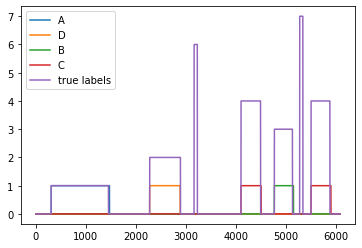

[0.941789448261261, 0.8886849880218506, 0.0, 0.759943425655365] 0.7884865005192108


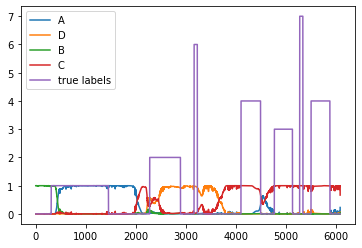


 subject: S3


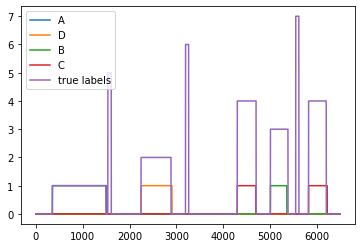

[0.8615401983261108, 0.47448861598968506, 0.0, 0.8062015771865845] 0.6774701873935264


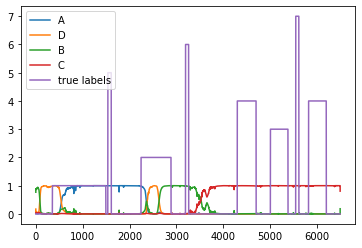


 subject: S4


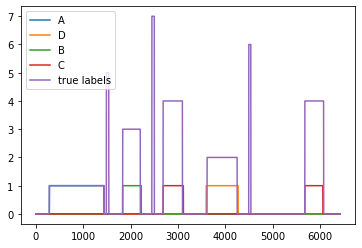

[0.7478682994842529, 0.9993598461151123, 0.0, 0.6605657339096069] 0.7371015514438581


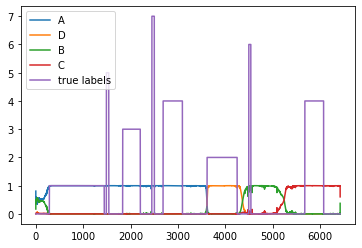


 subject: S5


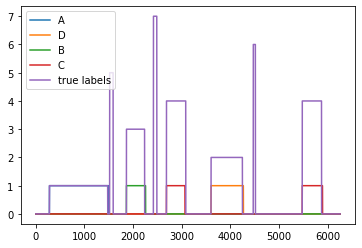

[0.8308194279670715, 0.9112057685852051, 0.3730911910533905, 0.6666666865348816] 0.7562284320593653


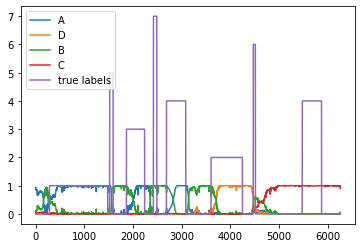


 subject: S6


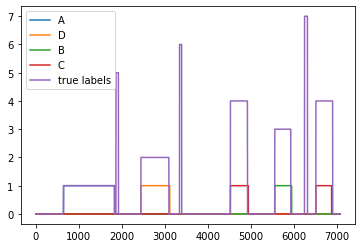

[0.8199077844619751, 0.8506896495819092, 0.6072927117347717, 0.6482294201850891] 0.7490276848444296


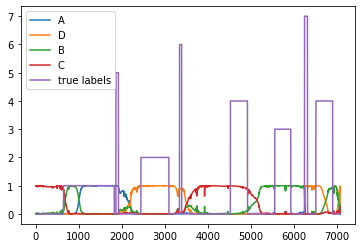


 subject: S7


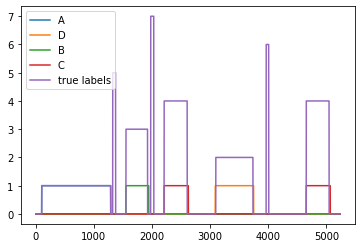

[0.8540178537368774, 0.9479396939277649, 0.6543625593185425, 0.6644124984741211] 0.7997197121820616


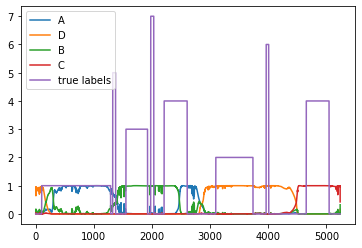


 subject: S8


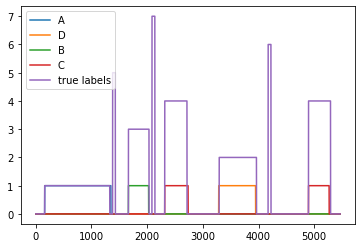

[0.85359126329422, 0.9847884178161621, 0.0, 0.6644295454025269] 0.7293937188019967


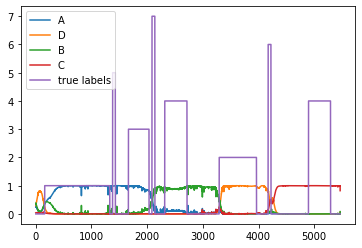


 subject: S9


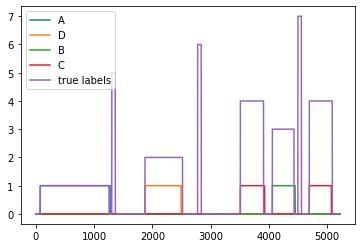

[1.0, 1.0, 0.0, 0.7599168419837952] 0.849132525083612


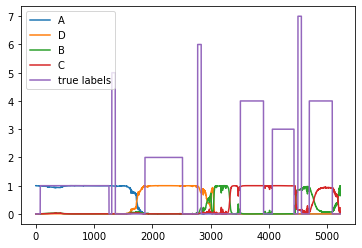


 subject: S10


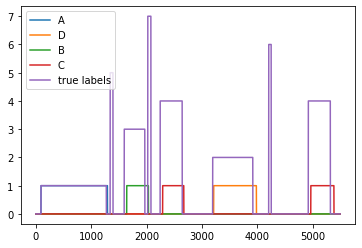

[0.7370014190673828, 0.9653019309043884, 0.4554811418056488, 0.6405794024467468] 0.6947420337311171


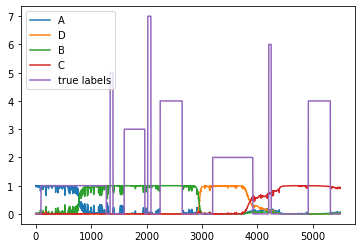


 subject: S11


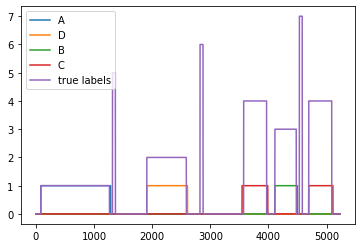

[0.7260369658470154, 0.0, 0.0, 0.8112820386886597] 0.560276787239218


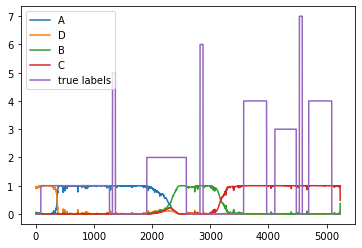


 subject: S13


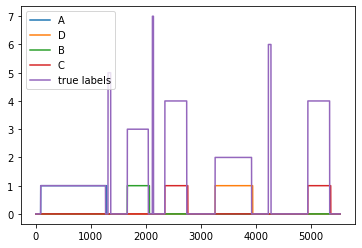

[0.6374874711036682, 0.8860228657722473, 0.2564852237701416, 0.6661161184310913] 0.631515521396874


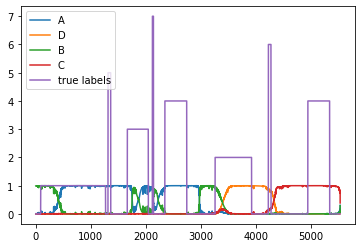


 subject: S14


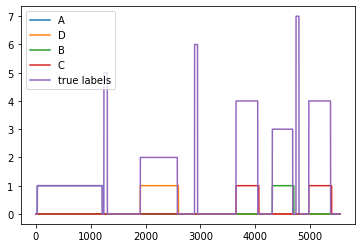

[0.9052534103393555, 0.916886031627655, 0.5664457678794861, 0.5986170172691345] 0.7666852863290301


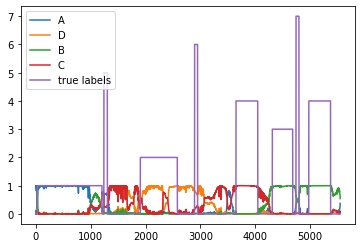


 subject: S15


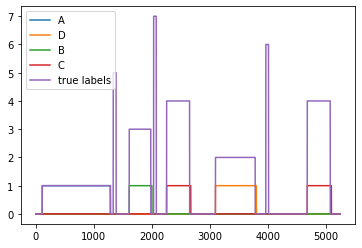

[0.7389588952064514, 0.9858282804489136, 0.5687054395675659, 0.6709385514259338] 0.743908985794516


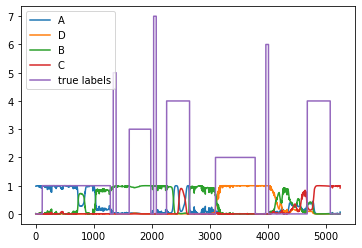


 subject: S16


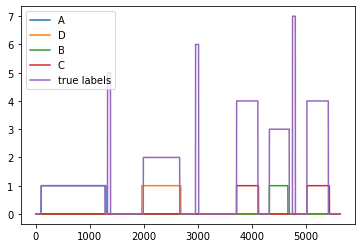

[0.22143502533435822, 1.0, 0.0, 0.24921712279319763] 0.3665970036248982


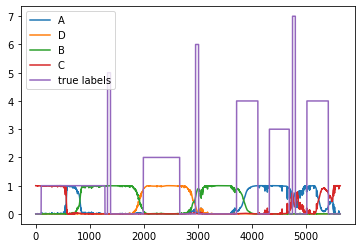


 subject: S17


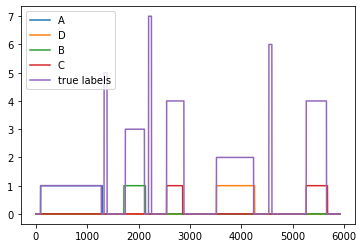

[0.6824480891227722, 0.5855304002761841, 0.4758507311344147, 0.4791238605976105] 0.5670051130695045


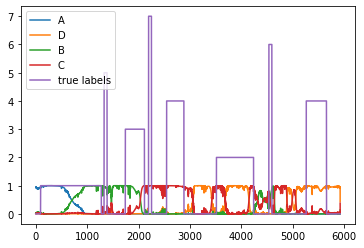

In [6]:
results_fcm = {}
for i in range(NB_CLASSES):
	results_fcm["class " + str(i)] = []
results_fcm["accuracy"] = []

phases_list = ["A", "D", "B", "C"]

for s in subjects:
    print("\n subject:", s)

    # physiological signals
    data = pd.read_pickle(path + s +"/"+ s +".pkl")
    eda = data["signal"]["wrist"]["EDA"].flatten()
    ecg = data["signal"]["wrist"]["BVP"].flatten()
    temp = data["signal"]["wrist"]["TEMP"].flatten()
    
    labels_true = data["label"]
    time_labels = np.arange(0, labels_true.size, 1) * (1/LABEL_RATE) + INIT_TIME

    signal, time = preprocessing(eda, ecg, temp, cardio_sampling_rate=CARDIO_SAMPLING_RATE, bvp=True, init_time=INIT_TIME)

    # seeding

    score_s = score[score["subject"] == s]
    # there is a little shift beween time labels and the actual start
    start_base_questionnaire = score_s[score_s["phase"] == "A"]["start"].values
    start_base_label = time_labels[np.argmax(labels_true == 1)]
    time_shift = start_base_questionnaire -start_base_label

    u_init = init_membership(score_s=score_s, time=time, nb_classes=NB_CLASSES, time_shift=time_shift, one_hot=True)
    for i in range(NB_CLASSES):
        plt.plot(time, u_init[:,i], label=phases_list[i])
    plt.plot(time_labels, labels_true, label="true labels")
    plt.legend(loc="upper left")
    plt.show()

    fcm = CMeans(signal, time)
    labels_hat, U, time_hat = fcm.run(nb_classes=NB_CLASSES, seq_len=SEQ_LEN, u_init=u_init,
                            max_iter=300, tol=1e-4)

    labels_true_down = resampling_labels(labels_true, labels_hat, time_labels, time_hat)

    list_acc, over_all_accuracy = accuracy(labels_true=labels_true_down, labels_hat=labels_hat, classes=list(range(1, NB_CLASSES+1)))
    for i in range(NB_CLASSES):
        results_fcm["class " + str(i)].append(list_acc[i])
    results_fcm["accuracy"].append(over_all_accuracy)
    print(list_acc, over_all_accuracy)

    for i in range(4):
        plt.plot(time_hat, U[:,i], label=phases_list[i])
    plt.plot(time_labels, labels_true, label="true labels")
    plt.legend(loc="upper left")
    plt.show()

In [7]:
results_fcm = pd.DataFrame(results_fcm, index=subjects)
print(results_fcm)
print(results_fcm.describe().round(2))

      class 0   class 1   class 2   class 3  accuracy
S2   0.941789  0.888685  0.000000  0.759943  0.788487
S3   0.861540  0.474489  0.000000  0.806202  0.677470
S4   0.747868  0.999360  0.000000  0.660566  0.737102
S5   0.830819  0.911206  0.373091  0.666667  0.756228
S6   0.819908  0.850690  0.607293  0.648229  0.749028
S7   0.854018  0.947940  0.654363  0.664412  0.799720
S8   0.853591  0.984788  0.000000  0.664430  0.729394
S9   1.000000  1.000000  0.000000  0.759917  0.849133
S10  0.737001  0.965302  0.455481  0.640579  0.694742
S11  0.726037  0.000000  0.000000  0.811282  0.560277
S13  0.637487  0.886023  0.256485  0.666116  0.631516
S14  0.905253  0.916886  0.566446  0.598617  0.766685
S15  0.738959  0.985828  0.568705  0.670939  0.743909
S16  0.221435  1.000000  0.000000  0.249217  0.366597
S17  0.682448  0.585530  0.475851  0.479124  0.567005
       class 0  class 1  class 2  class 3  accuracy
count    15.00    15.00    15.00    15.00     15.00
mean      0.77     0.83     0.26

In [8]:
print(results_fcm.describe())

         class 0    class 1    class 2    class 3   accuracy
count  15.000000  15.000000  15.000000  15.000000  15.000000
mean    0.770544   0.826448   0.263848   0.649749   0.694486
std     0.181254   0.275546   0.272020   0.138523   0.121694
min     0.221435   0.000000   0.000000   0.249217   0.366597
25%     0.731519   0.868356   0.000000   0.644404   0.654493
50%     0.819908   0.916886   0.256485   0.664430   0.737102
75%     0.857779   0.985308   0.521148   0.715428   0.761457
max     1.000000   1.000000   0.654363   0.811282   0.849133


Clustering with deep fuzzy c-means.


 subject: S2


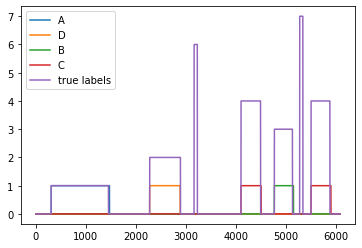

Pre-training: 100%|██████████| 1/1 [01:52<00:00, 112.47s/epoch, loss=59.5]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:53<01:53, 113.23s/epoch, loss=(62.56, 217.67)]

range tensor(0.9961)


Training: 100%|██████████| 2/2 [03:49<00:00, 114.68s/epoch, loss=(76.35, 1210.33)]

range tensor(0.9922)
[0.9906697869300842, 0.9822849631309509, 0.4920985698699951, 0.05261489748954773] 0.7339044652128764


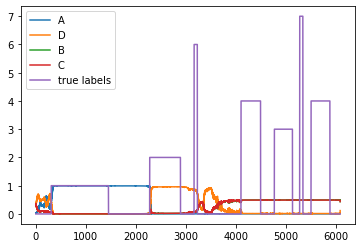


 subject: S3


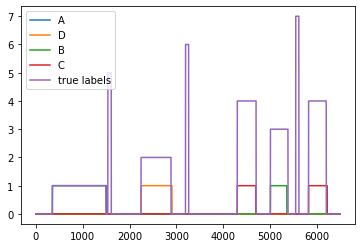

Pre-training: 100%|██████████| 1/1 [01:58<00:00, 118.05s/epoch, loss=43.9]


init range tensor(1.)


Training:  50%|█████     | 1/2 [02:00<02:00, 120.09s/epoch, loss=(34.87, 110.03)]

range tensor(0.8766)


Training: 100%|██████████| 2/2 [04:02<00:00, 121.08s/epoch, loss=(30.44, 910.95)]

range tensor(0.7424)
[0.9817531108856201, 0.9681870937347412, 0.0, 0.8028374314308167] 0.8563138841567292


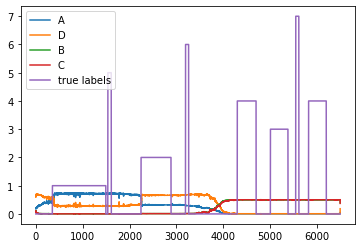


 subject: S4


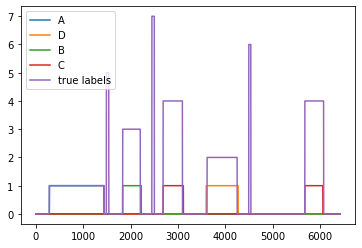

Pre-training: 100%|██████████| 1/1 [01:56<00:00, 116.85s/epoch, loss=268]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:58<01:58, 118.51s/epoch, loss=(51.45, 127.38)]

range tensor(0.9996)


Training: 100%|██████████| 2/2 [03:56<00:00, 118.41s/epoch, loss=(38.49, 1312.11)]

range tensor(0.9983)
[0.8580028414726257, 0.9976322054862976, 0.0, 0.9849246144294739] 0.8666673681220112


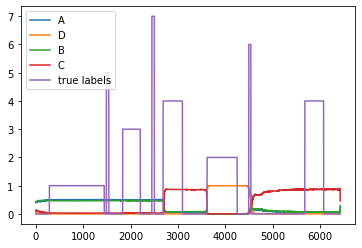


 subject: S5


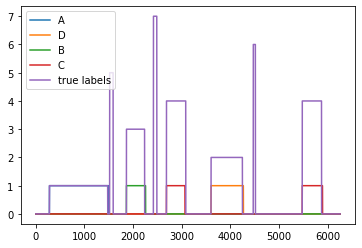

Pre-training: 100%|██████████| 1/1 [01:54<00:00, 114.37s/epoch, loss=55]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:55<01:55, 115.36s/epoch, loss=(35.51, 69.68)]

range tensor(0.9934)


Training: 100%|██████████| 2/2 [03:50<00:00, 115.36s/epoch, loss=(30.25, 1179.41)]

range tensor(0.9848)
[0.9894542694091797, 1.0, 0.9529298543930054, 0.9943499565124512] 0.9885576399159337


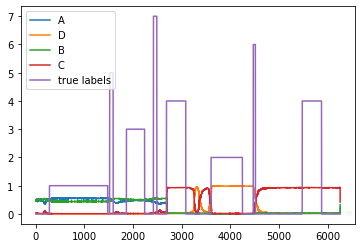


 subject: S6


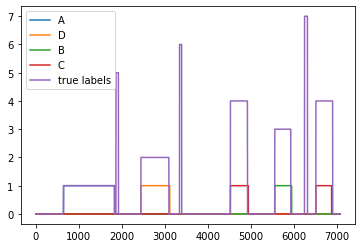

Pre-training: 100%|██████████| 1/1 [02:17<00:00, 137.74s/epoch, loss=50.6]


init range tensor(1.)


Training:  50%|█████     | 1/2 [02:13<02:13, 133.67s/epoch, loss=(52.54, 100.11)]

range tensor(0.9926)


Training: 100%|██████████| 2/2 [04:26<00:00, 133.45s/epoch, loss=(49.89, 1492.22)]

range tensor(0.9816)
[0.9835458993911743, 0.9904054403305054, 0.9477895498275757, 0.9649731516838074] 0.9755143860823018


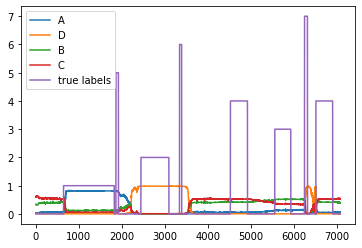


 subject: S7


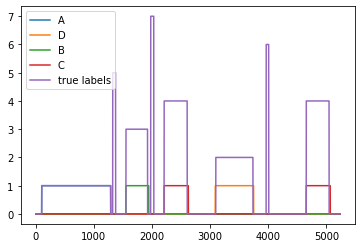

Pre-training: 100%|██████████| 1/1 [01:37<00:00, 97.22s/epoch, loss=29.3]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:36<01:36, 96.53s/epoch, loss=(27.42, 108.45)]

range tensor(0.9894)


Training: 100%|██████████| 2/2 [03:14<00:00, 97.32s/epoch, loss=(27.77, 1049.26)]

range tensor(0.9610)
[0.9762400388717651, 0.965859055519104, 0.9383296370506287, 0.9881929159164429] 0.9723320364792504


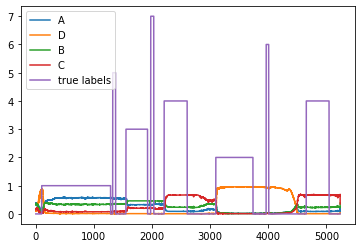


 subject: S8


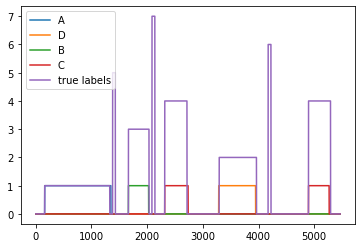

Pre-training: 100%|██████████| 1/1 [01:39<00:00, 99.91s/epoch, loss=18.6]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:41<01:41, 101.76s/epoch, loss=(82.26, 237.05)]

range tensor(0.9998)


Training: 100%|██████████| 2/2 [03:23<00:00, 101.87s/epoch, loss=(73.07, 1580.13)]

range tensor(0.9993)
[0.9351884722709656, 0.9874511361122131, 0.8350279927253723, 0.9177383184432983] 0.9284525790349417


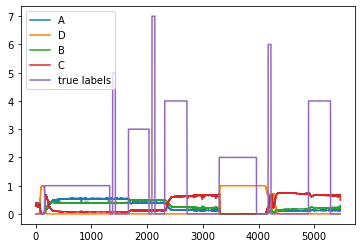


 subject: S9


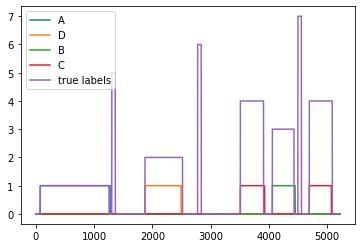

Pre-training: 100%|██████████| 1/1 [01:35<00:00, 95.13s/epoch, loss=314]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:36<01:36, 96.36s/epoch, loss=(40.22, 50.59)]

range tensor(0.9998)


Training: 100%|██████████| 2/2 [03:12<00:00, 96.48s/epoch, loss=(31.31, 677.7)]

range tensor(0.9998)
[1.0, 1.0, 0.5056602358818054, 0.15292790532112122] 0.756741220735786


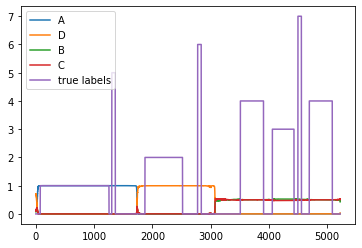


 subject: S10


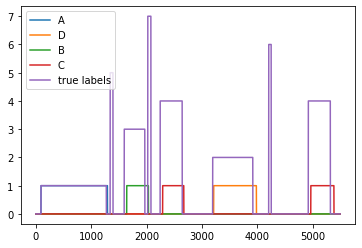

Pre-training: 100%|██████████| 1/1 [01:41<00:00, 101.98s/epoch, loss=29]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:44<01:44, 104.67s/epoch, loss=(46.31, 415.65)]

range tensor(0.9899)


Training: 100%|██████████| 2/2 [03:29<00:00, 104.88s/epoch, loss=(34.32, 993.3)] 

range tensor(0.9719)
[0.9483268857002258, 1.0, 0.8309394717216492, 0.9194864630699158] 0.9388273936941014


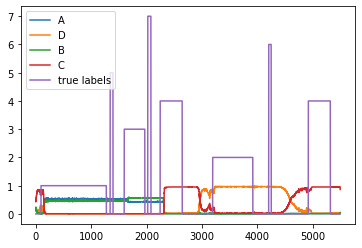


 subject: S11


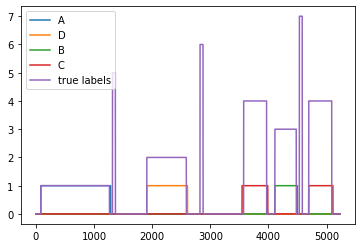

Pre-training: 100%|██████████| 1/1 [01:36<00:00, 96.49s/epoch, loss=73.1]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:37<01:37, 97.85s/epoch, loss=(111.31, 109.83)]

range tensor(0.9806)


Training: 100%|██████████| 2/2 [03:17<00:00, 98.84s/epoch, loss=(64.61, 668.39)] 

range tensor(0.9774)
[0.9897003173828125, 0.9823970794677734, 0.003898635506629944, 0.8115811944007874] 0.8703374961830481


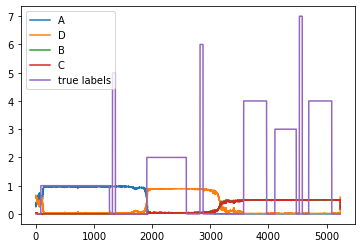


 subject: S13


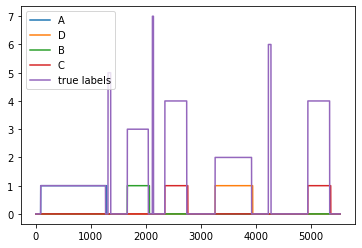

Pre-training: 100%|██████████| 1/1 [01:41<00:00, 101.38s/epoch, loss=108]


init range tensor(1.)


Training:  50%|█████     | 1/2 [17:24<17:24, 1044.89s/epoch, loss=(36.84, 107.84)]

range tensor(0.9990)


Training: 100%|██████████| 2/2 [38:22<00:00, 1151.18s/epoch, loss=(66.82, 1050.72)]

range tensor(0.9982)
[0.9670476913452148, 0.9952108263969421, 0.8992896676063538, 0.9861111044883728] 0.96891582965254


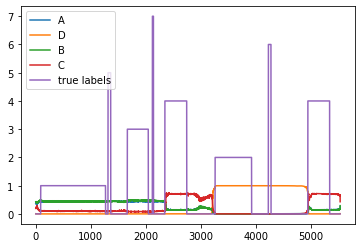


 subject: S14


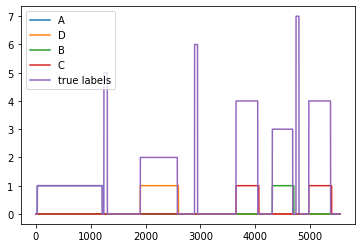

Pre-training: 100%|██████████| 1/1 [01:41<00:00, 101.77s/epoch, loss=752]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:42<01:42, 102.75s/epoch, loss=(31.7, 48.21)]

range tensor(0.9464)


Training: 100%|██████████| 2/2 [03:25<00:00, 102.81s/epoch, loss=(42.58, 944.36)]

range tensor(0.8411)
[0.9838809370994568, 0.9925786256790161, 0.4901488423347473, 0.023768847808241844] 0.7280908639523337


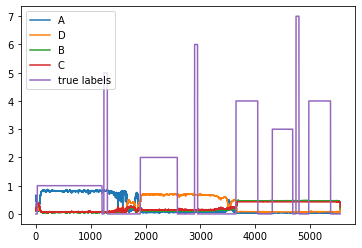


 subject: S15


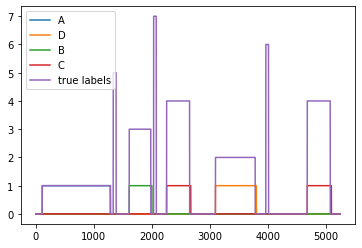

Pre-training: 100%|██████████| 1/1 [01:35<00:00, 95.73s/epoch, loss=359]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:36<01:36, 96.79s/epoch, loss=(44.18, 98.7)]

range tensor(0.9798)


Training: 100%|██████████| 2/2 [03:13<00:00, 96.76s/epoch, loss=(50.19, 1047.05)]

range tensor(0.9471)
[0.9953145980834961, 0.9778492450714111, 0.9338615536689758, 0.9550061821937561] 0.9731582424843079


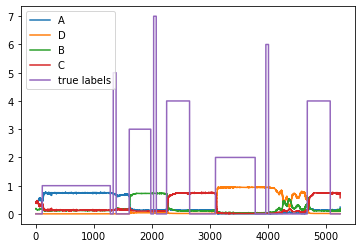


 subject: S16


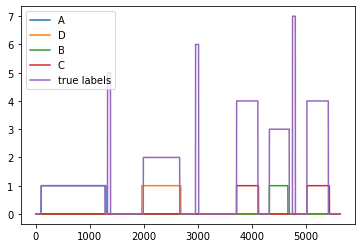

Pre-training: 100%|██████████| 1/1 [01:47<00:00, 107.28s/epoch, loss=46.4]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:48<01:48, 108.69s/epoch, loss=(10.17, 127.87)]

range tensor(0.9996)


Training: 100%|██████████| 2/2 [03:37<00:00, 108.88s/epoch, loss=(8.79, 1238.16)]

range tensor(0.9991)
[0.9800139665603638, 1.0, 0.4775432348251343, 0.014782710000872612] 0.7266235550968974


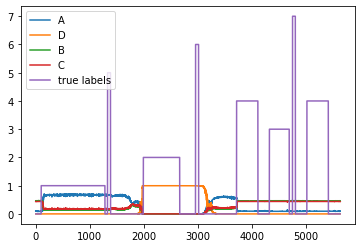


 subject: S17


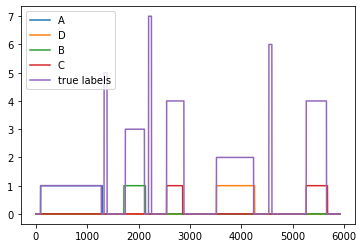

Pre-training: 100%|██████████| 1/1 [01:50<00:00, 110.67s/epoch, loss=686]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:52<01:52, 112.01s/epoch, loss=(160.1, 117.33)]

range tensor(0.9772)


Training: 100%|██████████| 2/2 [03:42<00:00, 111.50s/epoch, loss=(86.35, 636.82)]

range tensor(0.9671)
[1.0, 0.9734702706336975, 0.9771593809127808, 0.9607403874397278] 0.9813300216162288


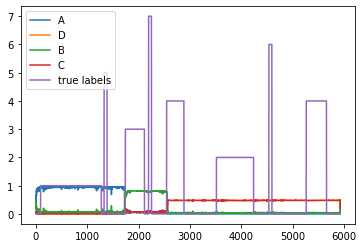

In [9]:
results_dfcm = {}
for i in range(NB_CLASSES):
	results_dfcm["class " + str(i)] = []
results_dfcm["accuracy"] = []

phases_list = ["A", "D", "B", "C"]

for s in subjects:
    print("\n subject:", s)

    # physiological signals
    data = pd.read_pickle(path + s +"/"+ s +".pkl")
    eda = data["signal"]["wrist"]["EDA"].flatten()
    ecg = data["signal"]["wrist"]["BVP"].flatten()
    temp = data["signal"]["wrist"]["TEMP"].flatten()
    
    labels_true = data["label"]
    time_labels = np.arange(0, labels_true.size, 1) * (1/LABEL_RATE) + INIT_TIME

    signal, time = preprocessing(eda, ecg, temp, cardio_sampling_rate=CARDIO_SAMPLING_RATE, bvp=True, init_time=INIT_TIME)

    # seeding

    score_s = score[score["subject"] == s]
    # there is a little shift beween time labels and the actual start
    start_base_questionnaire = score_s[score_s["phase"] == "A"]["start"].values
    start_base_label = time_labels[np.argmax(labels_true == 1)]
    time_shift = start_base_questionnaire -start_base_label

    u_init = init_membership(score_s=score_s, time=time, nb_classes=NB_CLASSES, time_shift=time_shift, one_hot=True)
    for i in range(NB_CLASSES):
        plt.plot(time, u_init[:,i], label=phases_list[i])
    plt.plot(time_labels, labels_true, label="true labels")
    plt.legend(loc="upper left")
    plt.show()

    dfcm = DeepCMeams(signal, time)
    labels_hat, U, time_hat = dfcm.run(nb_classes=NB_CLASSES, seq_len=SEQ_LEN, u_init=u_init, epochs_pre=1, epochs_train=2, batch_size=128, 
            embedding=30, lr_pretrain=5e-5, lr_train=5e-5, sigma=1, gamma=0.5, pre_train_cluster=False)
    

    labels_true_down = resampling_labels(labels_true, labels_hat, time_labels, time_hat)

    list_acc, over_all_accuracy = accuracy(labels_true=labels_true_down, labels_hat=labels_hat, classes=list(range(1, NB_CLASSES+1)))
    for i in range(NB_CLASSES):
        results_dfcm["class " + str(i)].append(list_acc[i])
    results_dfcm["accuracy"].append(over_all_accuracy)
    print(list_acc, over_all_accuracy)

    for i in range(4):
        plt.plot(time_hat, U[:,i], label=phases_list[i])
    plt.plot(time_labels, labels_true, label="true labels")
    plt.legend(loc="upper left")
    plt.show()


In [10]:
results_dfcm = pd.DataFrame(results_dfcm, index=subjects)
print(results_dfcm)
print(results_dfcm.describe().round(2))

      class 0   class 1   class 2   class 3  accuracy
S2   0.990670  0.982285  0.492099  0.052615  0.733904
S3   0.981753  0.968187  0.000000  0.802837  0.856314
S4   0.858003  0.997632  0.000000  0.984925  0.866667
S5   0.989454  1.000000  0.952930  0.994350  0.988558
S6   0.983546  0.990405  0.947790  0.964973  0.975514
S7   0.976240  0.965859  0.938330  0.988193  0.972332
S8   0.935188  0.987451  0.835028  0.917738  0.928453
S9   1.000000  1.000000  0.505660  0.152928  0.756741
S10  0.948327  1.000000  0.830939  0.919486  0.938827
S11  0.989700  0.982397  0.003899  0.811581  0.870337
S13  0.967048  0.995211  0.899290  0.986111  0.968916
S14  0.983881  0.992579  0.490149  0.023769  0.728091
S15  0.995315  0.977849  0.933862  0.955006  0.973158
S16  0.980014  1.000000  0.477543  0.014783  0.726624
S17  1.000000  0.973470  0.977159  0.960740  0.981330
       class 0  class 1  class 2  class 3  accuracy
count    15.00    15.00    15.00    15.00     15.00
mean      0.97     0.99     0.62

In [11]:
print(results_dfcm.describe())

         class 0    class 1    class 2    class 3   accuracy
count  15.000000  15.000000  15.000000  15.000000  15.000000
mean    0.971943   0.987555   0.618978   0.702002   0.884384
std     0.036317   0.011970   0.371232   0.405297   0.102042
min     0.858003   0.965859   0.000000   0.014783   0.726624
25%     0.971644   0.980067   0.483846   0.477883   0.806528
50%     0.983546   0.990405   0.830939   0.919486   0.928453
75%     0.990185   0.998816   0.936096   0.974949   0.972745
max     1.000000   1.000000   0.977159   0.994350   0.988558


Clustering with deep fuzzy c-means. The pre-training minimises the clustering loss.


 subject: S2


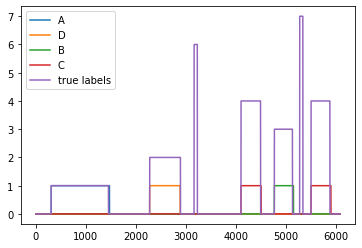

Pre-training: 100%|██████████| 1/1 [02:04<00:00, 124.47s/epoch, loss=316]


init range tensor(1.)


Training:  50%|█████     | 1/2 [02:13<02:13, 133.03s/epoch, loss=(90.27, 3149.34)]

range tensor(1.)


Training: 100%|██████████| 2/2 [04:20<00:00, 130.20s/epoch, loss=(95.91, 3295.71)]

range tensor(1.)
[0.9252108335494995, 0.9002463221549988, 0.8477672338485718, 0.8284438848495483] 0.8837833160263067


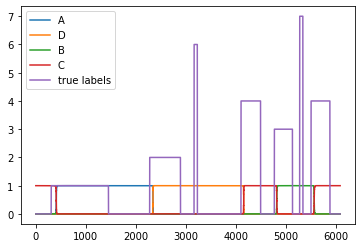


 subject: S3


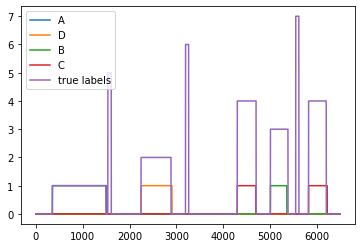

Pre-training: 100%|██████████| 1/1 [02:11<00:00, 131.66s/epoch, loss=143]


init range tensor(1.)


Training:  50%|█████     | 1/2 [02:11<02:11, 131.35s/epoch, loss=(35.02, 4866.07)]

range tensor(1.)


Training: 100%|██████████| 2/2 [04:22<00:00, 131.03s/epoch, loss=(28.2, 2772.59)] 

range tensor(1.0000)
[0.9329385161399841, 0.9373529553413391, 0.8419215679168701, 0.8386353254318237] 0.896103066439523


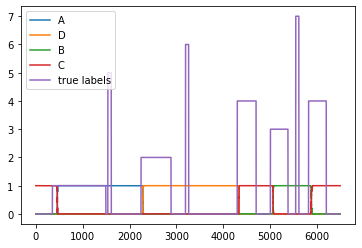


 subject: S4


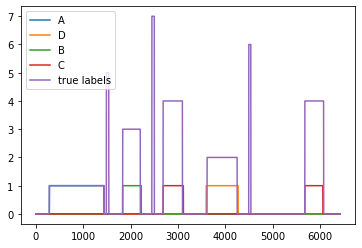

Pre-training: 100%|██████████| 1/1 [02:05<00:00, 125.16s/epoch, loss=177]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:59<01:59, 119.84s/epoch, loss=(50.14, 4305.78)]

range tensor(1.)


Training: 100%|██████████| 2/2 [03:59<00:00, 119.91s/epoch, loss=(41.04, 3775.43)]

range tensor(1.)
[0.9093959331512451, 0.9543634653091431, 0.8259109258651733, 0.8490800857543945] 0.8911201014304428


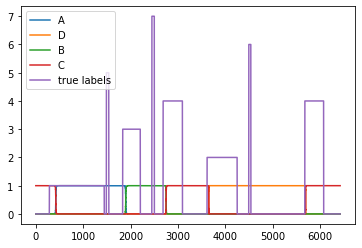


 subject: S5


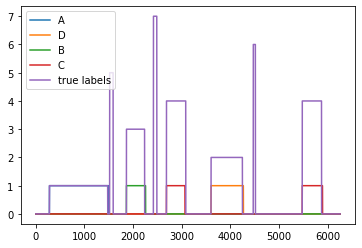

Pre-training: 100%|██████████| 1/1 [01:55<00:00, 115.33s/epoch, loss=155]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:55<01:55, 115.49s/epoch, loss=(42.74, 7500.73)]

range tensor(1.0000)


Training: 100%|██████████| 2/2 [03:51<00:00, 115.55s/epoch, loss=(37.24, 3691.46)]

range tensor(1.0000)
[0.9232024550437927, 0.9216443300247192, 0.7970592975616455, 0.8165119290351868] 0.8782387587244752


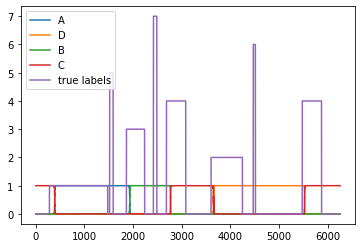


 subject: S6


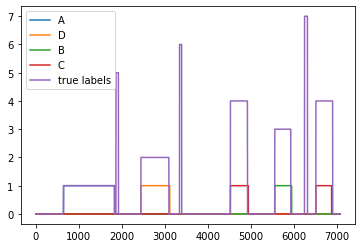

Pre-training: 100%|██████████| 1/1 [02:17<00:00, 137.17s/epoch, loss=228]


init range tensor(1.)


Training:  50%|█████     | 1/2 [02:19<02:19, 139.96s/epoch, loss=(85.27, 3984.55)]

range tensor(1.)


Training: 100%|██████████| 2/2 [04:33<00:00, 136.84s/epoch, loss=(101.73, 2878.5)]

range tensor(1.)
[0.9400845766067505, 0.9180071353912354, 0.8669488430023193, 0.8508208394050598] 0.9022143693542991


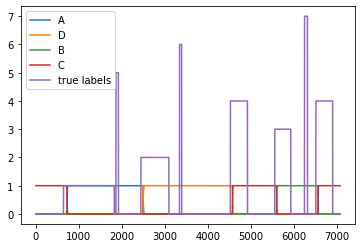


 subject: S7


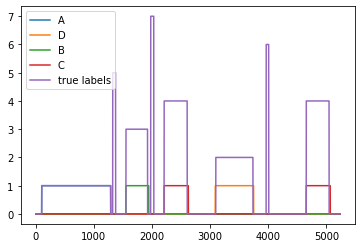

Pre-training: 100%|██████████| 1/1 [01:36<00:00, 96.58s/epoch, loss=768]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:37<01:37, 97.27s/epoch, loss=(55.93, 5756.23)]

range tensor(1.)


Training: 100%|██████████| 2/2 [03:15<00:00, 97.55s/epoch, loss=(36.06, 3162.53)]

range tensor(1.)
[0.9251120090484619, 0.902778685092926, 0.8539093136787415, 0.8154247999191284] 0.8801351238286479


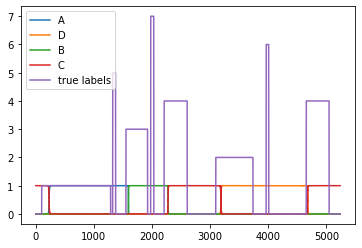


 subject: S8


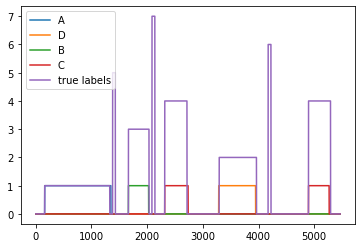

Pre-training: 100%|██████████| 1/1 [01:40<00:00, 100.97s/epoch, loss=100]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:43<01:43, 103.36s/epoch, loss=(50.8, 6423.78)]

range tensor(1.0000)


Training: 100%|██████████| 2/2 [03:26<00:00, 103.15s/epoch, loss=(78.11, 4241.01)]

range tensor(1.0000)
[0.9130972027778625, 0.901252806186676, 0.8593325614929199, 0.8090647459030151] 0.8745996256239601


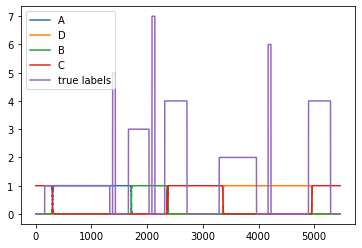


 subject: S9


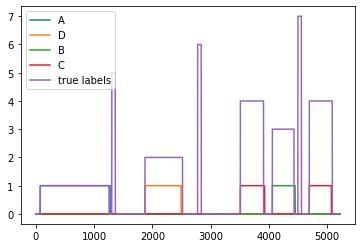

Pre-training: 100%|██████████| 1/1 [01:37<00:00, 97.40s/epoch, loss=268]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:45<01:45, 105.38s/epoch, loss=(57.61, 3968.07)]

range tensor(1.)


Training: 100%|██████████| 2/2 [03:29<00:00, 104.71s/epoch, loss=(52.04, 2600.14)]

range tensor(1.)
[0.9040774703025818, 0.9295189380645752, 0.8152644038200378, 0.8180620074272156] 0.8739757525083612


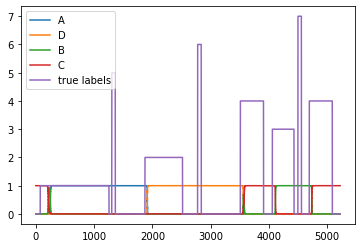


 subject: S10


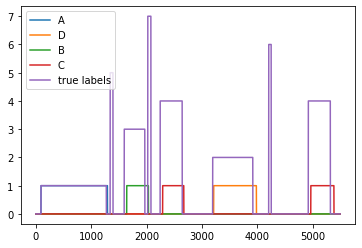

Pre-training: 100%|██████████| 1/1 [01:41<00:00, 101.70s/epoch, loss=77.3]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:41<01:41, 101.65s/epoch, loss=(76.19, 11622.55)]

range tensor(1.)


Training: 100%|██████████| 2/2 [03:23<00:00, 101.69s/epoch, loss=(92.72, 5359.41)] 

range tensor(1.)
[0.8470298647880554, 0.8575259447097778, 0.6647225618362427, 0.6432994604110718] 0.7705175596040128


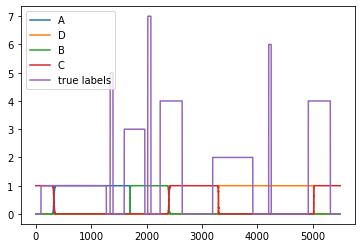


 subject: S11


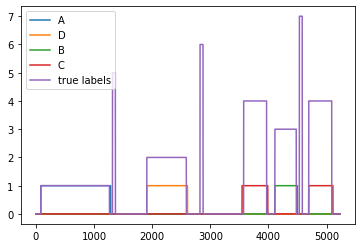

Pre-training: 100%|██████████| 1/1 [01:36<00:00, 96.54s/epoch, loss=480]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:37<01:37, 97.07s/epoch, loss=(89.66, 4265.57)]

range tensor(1.0000)


Training: 100%|██████████| 2/2 [03:14<00:00, 97.10s/epoch, loss=(126.4, 2482.97)]

range tensor(1.0000)
[0.9254528880119324, 0.9522318243980408, 0.8441987633705139, 0.8337482810020447] 0.8959563599476237


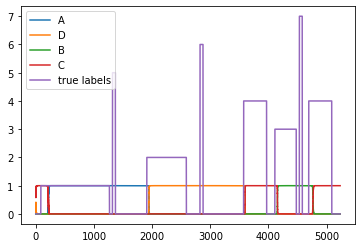


 subject: S13


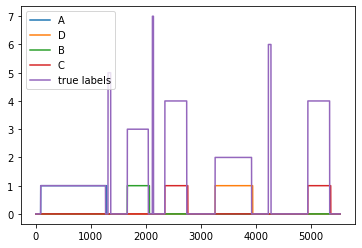

Pre-training: 100%|██████████| 1/1 [01:42<00:00, 102.02s/epoch, loss=1415.76]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:42<01:42, 102.66s/epoch, loss=(37.66, 5591.62)]

range tensor(1.)


Training: 100%|██████████| 2/2 [03:24<00:00, 102.50s/epoch, loss=(36.79, 5216.33)]

range tensor(1.)
[0.9108368158340454, 0.9140805006027222, 0.8421816229820251, 0.7957632541656494] 0.8702533282302194


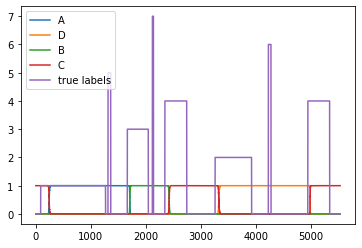


 subject: S14


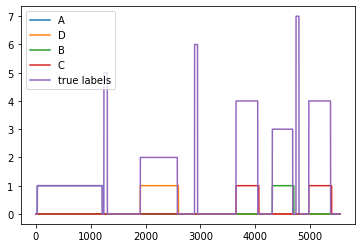

Pre-training: 100%|██████████| 1/1 [01:42<00:00, 102.46s/epoch, loss=155]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:42<01:42, 102.94s/epoch, loss=(55.92, 5480.1)]

range tensor(1.)


Training: 100%|██████████| 2/2 [03:26<00:00, 103.03s/epoch, loss=(67.66, 3080.3)]

range tensor(1.)
[0.9199947714805603, 0.9151792526245117, 0.8446056246757507, 0.8030813932418823] 0.8777774329692155


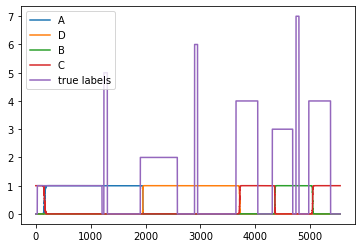


 subject: S15


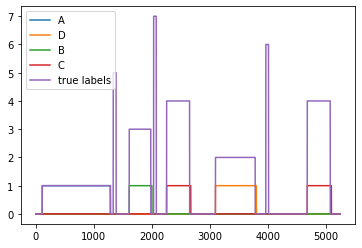

Pre-training: 100%|██████████| 1/1 [01:40<00:00, 100.69s/epoch, loss=480]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:42<01:42, 102.78s/epoch, loss=(65.56, 6493.16)]

range tensor(1.0000)


Training: 100%|██████████| 2/2 [03:34<00:00, 107.21s/epoch, loss=(55.26, 3411.89)]

range tensor(1.0000)
[0.89872145652771, 0.9053729772567749, 0.8269846439361572, 0.769892692565918] 0.8548635199867856


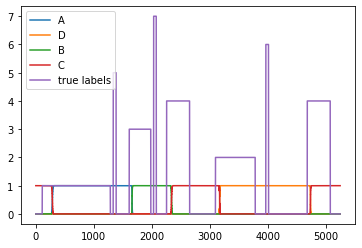


 subject: S16


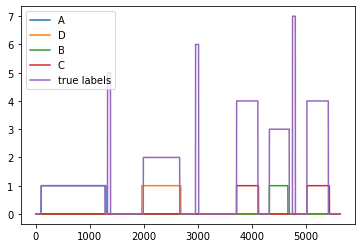

Pre-training: 100%|██████████| 1/1 [01:53<00:00, 113.62s/epoch, loss=461]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:54<01:54, 114.74s/epoch, loss=(28.06, 2743.64)]

range tensor(1.)


Training: 100%|██████████| 2/2 [03:47<00:00, 113.72s/epoch, loss=(41.95, 3180.98)]

range tensor(1.)
[0.9656252264976501, 0.9542442560195923, 0.8647868037223816, 0.8514991402626038] 0.9204596723589842


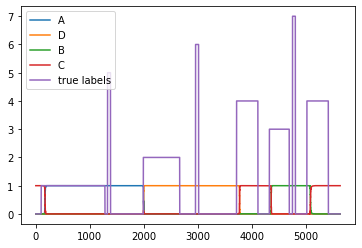


 subject: S17


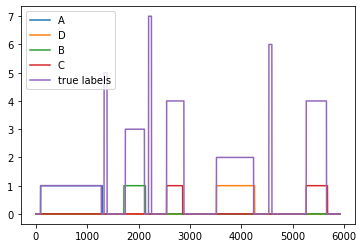

Pre-training: 100%|██████████| 1/1 [01:56<00:00, 116.30s/epoch, loss=529]


init range tensor(1.)


Training:  50%|█████     | 1/2 [01:57<01:57, 117.03s/epoch, loss=(63.71, 5735.36)]

range tensor(1.)


Training: 100%|██████████| 2/2 [03:48<00:00, 114.10s/epoch, loss=(144.05, 4537.36)]

range tensor(1.0000)
[0.8829503059387207, 0.8917320370674133, 0.8892948031425476, 0.731166660785675] 0.8438175507149983


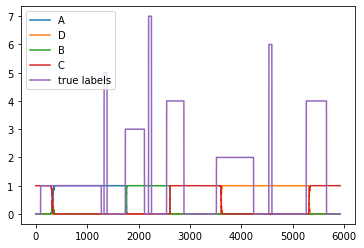

In [13]:
results_dfcm_c = {}
for i in range(NB_CLASSES):
	results_dfcm_c["class " + str(i)] = []
results_dfcm_c["accuracy"] = []

phases_list = ["A", "D", "B", "C"]

for s in subjects:
    print("\n subject:", s)

    # physiological signals
    data = pd.read_pickle(path + s +"/"+ s +".pkl")
    eda = data["signal"]["wrist"]["EDA"].flatten()
    ecg = data["signal"]["wrist"]["BVP"].flatten()
    temp = data["signal"]["wrist"]["TEMP"].flatten()
    
    labels_true = data["label"]
    time_labels = np.arange(0, labels_true.size, 1) * (1/LABEL_RATE) + INIT_TIME

    signal, time = preprocessing(eda, ecg, temp, cardio_sampling_rate=CARDIO_SAMPLING_RATE, bvp=True, init_time=INIT_TIME)

    # seeding

    score_s = score[score["subject"] == s]
    # there is a little shift beween time labels and the actual start
    start_base_questionnaire = score_s[score_s["phase"] == "A"]["start"].values
    start_base_label = time_labels[np.argmax(labels_true == 1)]
    time_shift = start_base_questionnaire -start_base_label

    u_init = init_membership(score_s=score_s, time=time, nb_classes=NB_CLASSES, time_shift=time_shift, one_hot=True)
    for i in range(NB_CLASSES):
        plt.plot(time, u_init[:,i], label=phases_list[i])
    plt.plot(time_labels, labels_true, label="true labels")
    plt.legend(loc="upper left")
    plt.show()

    dfcm = DeepCMeams(signal, time)
    labels_hat, U, time_hat = dfcm.run(nb_classes=NB_CLASSES, seq_len=SEQ_LEN, u_init=u_init, epochs_pre=1, epochs_train=2, batch_size=128, 
            embedding=30, lr_pretrain=5e-5, lr_train=5e-5, sigma=1, gamma=0.5, pre_train_cluster=True)
    

    labels_true_down = resampling_labels(labels_true, labels_hat, time_labels, time_hat)

    list_acc, over_all_accuracy = accuracy(labels_true=labels_true_down, labels_hat=labels_hat, classes=list(range(1, NB_CLASSES+1)))
    for i in range(NB_CLASSES):
        results_dfcm_c["class " + str(i)].append(list_acc[i])
    results_dfcm_c["accuracy"].append(over_all_accuracy)
    print(list_acc, over_all_accuracy)

    for i in range(4):
        plt.plot(time_hat, U[:,i], label=phases_list[i])
    plt.plot(time_labels, labels_true, label="true labels")
    plt.legend(loc="upper left")
    plt.show()


In [14]:
results_dfcm_c = pd.DataFrame(results_dfcm_c, index=subjects)
print(results_dfcm_c)
print(results_dfcm_c.describe().round(2))

      class 0   class 1   class 2   class 3  accuracy
S2   0.925211  0.900246  0.847767  0.828444  0.883783
S3   0.932939  0.937353  0.841922  0.838635  0.896103
S4   0.909396  0.954363  0.825911  0.849080  0.891120
S5   0.923202  0.921644  0.797059  0.816512  0.878239
S6   0.940085  0.918007  0.866949  0.850821  0.902214
S7   0.925112  0.902779  0.853909  0.815425  0.880135
S8   0.913097  0.901253  0.859333  0.809065  0.874600
S9   0.904077  0.929519  0.815264  0.818062  0.873976
S10  0.847030  0.857526  0.664723  0.643299  0.770518
S11  0.925453  0.952232  0.844199  0.833748  0.895956
S13  0.910837  0.914081  0.842182  0.795763  0.870253
S14  0.919995  0.915179  0.844606  0.803081  0.877777
S15  0.898721  0.905373  0.826985  0.769893  0.854864
S16  0.965625  0.954244  0.864787  0.851499  0.920460
S17  0.882950  0.891732  0.889295  0.731167  0.843818
       class 0  class 1  class 2  class 3  accuracy
count    15.00    15.00    15.00    15.00     15.00
mean      0.91     0.92     0.83

In [15]:
print(results_dfcm_c.describe())

         class 0    class 1    class 2    class 3   accuracy
count  15.000000  15.000000  15.000000  15.000000  15.000000
mean    0.914915   0.917035   0.832326   0.803633   0.874254
std     0.026734   0.026284   0.051484   0.054793   0.034208
min     0.847030   0.857526   0.664723   0.643299   0.770518
25%     0.906737   0.902016   0.826448   0.799422   0.872115
50%     0.919995   0.915179   0.844199   0.816512   0.878239
75%     0.925332   0.933436   0.856621   0.836192   0.893538
max     0.965625   0.954363   0.889295   0.851499   0.920460


Clustering with k-means.


 subject: S2


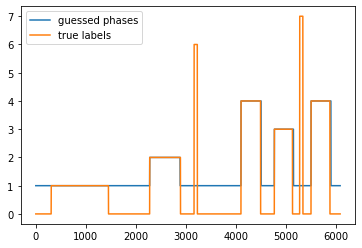

[1.0, 0.7029805779457092, 0.48525470495224, 0.0] 0.6366660176531672


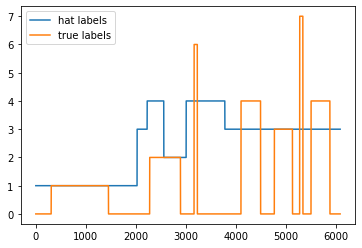


 subject: S3


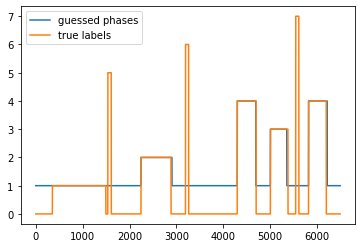

[0.2390974909067154, 0.1427319049835205, 0.0, 0.8062015771865845] 0.37246592844974447


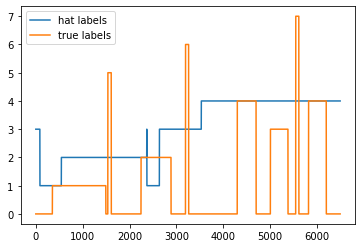


 subject: S4


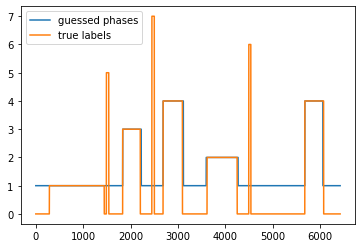

[0.0, 0.9995938539505005, 0.32200387120246887, 0.6605657339096069] 0.4725511755514754


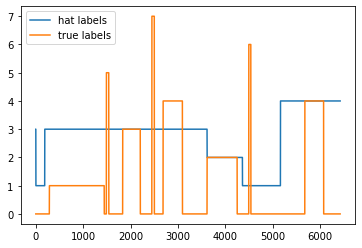


 subject: S5


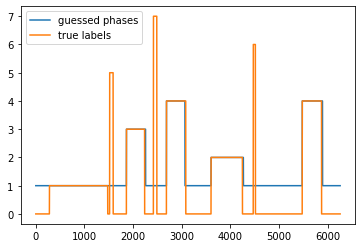

[0.0, 0.9059829115867615, 0.24029378592967987, 0.6666666865348816] 0.39260527749669183


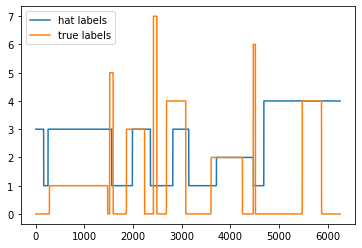


 subject: S6


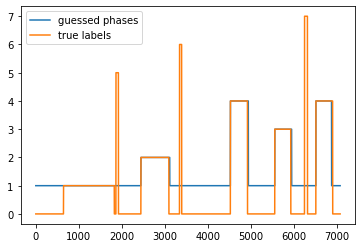

[0.0, 0.9370319247245789, 0.4172230660915375, 0.5993442535400391] 0.4747407159585146


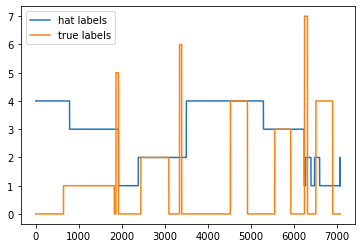


 subject: S7


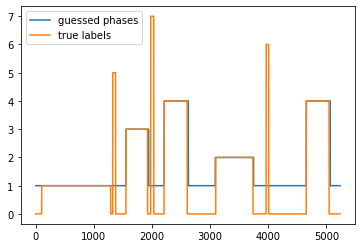

[0.1933671087026596, 0.9012728333473206, 0.34007543325424194, 0.6644124984741211] 0.47832475736278446


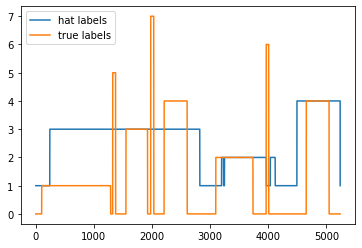


 subject: S8


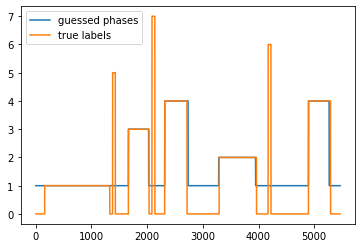

[0.2108260840177536, 0.9626224637031555, 0.3417125940322876, 0.6644295454025269] 0.5095361896838603


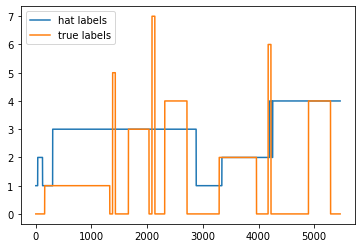


 subject: S9


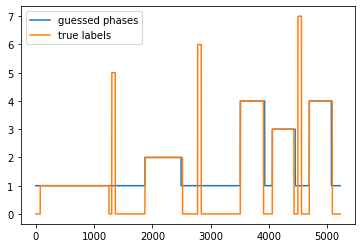

[1.0, 1.0, 0.6514886021614075, 0.6649831533432007] 0.8668896321070234


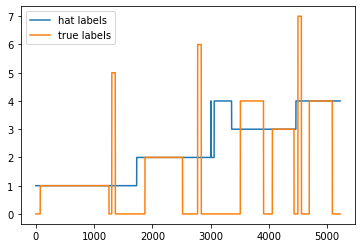


 subject: S10


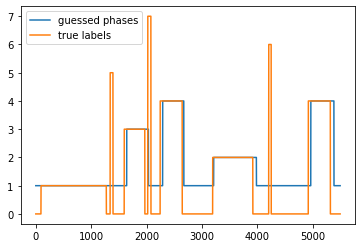

[0.7377508282661438, 0.9388585686683655, 0.4557906985282898, 0.6230691075325012] 0.68373899823565


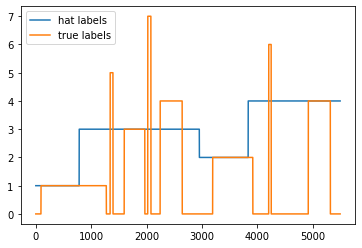


 subject: S11


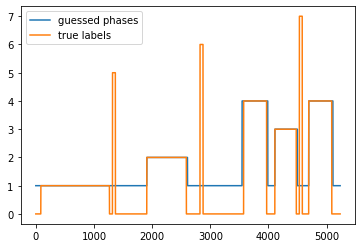

[0.7251059412956238, 0.0, 0.48199084401130676, 0.0] 0.42073937593482974


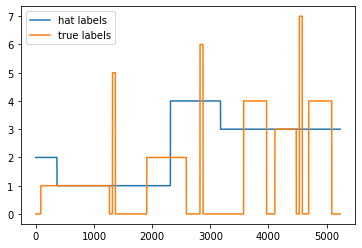


 subject: S13


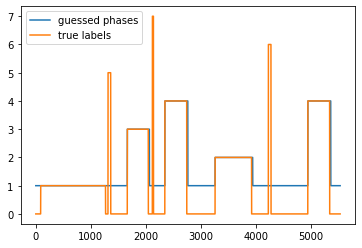

[0.3600378632545471, 0.8851607441902161, 0.2995550036430359, 0.6661161184310913] 0.5045152214165279


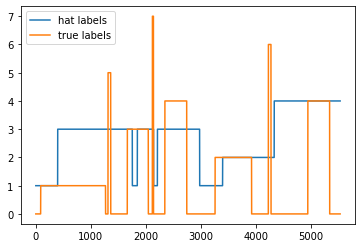


 subject: S14


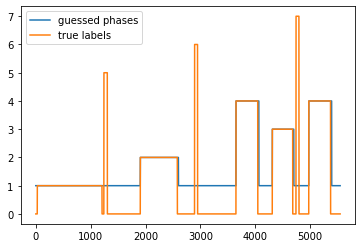

[0.8936824798583984, 0.9831346273422241, 0.6495157480239868, 0.5530331134796143] 0.7861014564713671


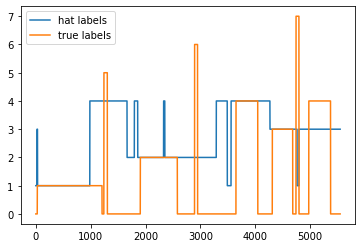


 subject: S15


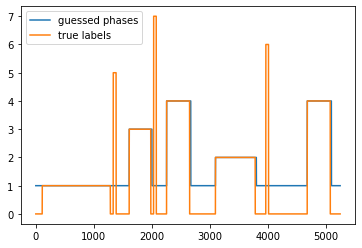

[0.7008116841316223, 0.9894582033157349, 0.5824800729751587, 0.6501620411872864] 0.7307358771060456


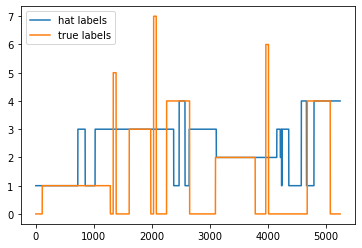


 subject: S16


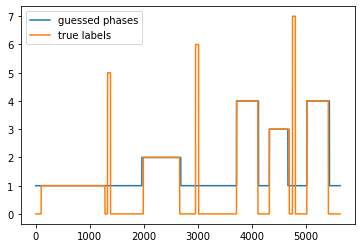

[0.5200172662734985, 1.0, 0.0, 0.4929671585559845] 0.5293907163193022


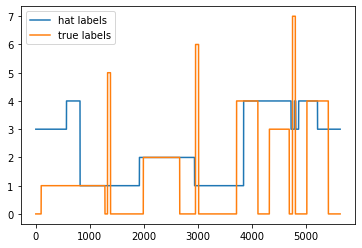


 subject: S17


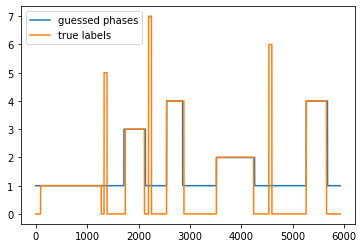

[0.8021268248558044, 0.5797838568687439, 0.5854599475860596, 0.48435306549072266] 0.6316199700698371


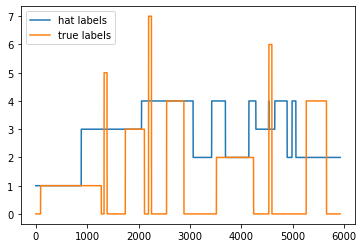

In [16]:
results_km = {}
for i in range(NB_CLASSES):
	results_km["class " + str(i)] = []
results_km["accuracy"] = []

phases_list = ["A", "D", "B", "C"]

for s in subjects:
    print("\n subject:", s)

    # physiological signals
    data = pd.read_pickle(path + s +"/"+ s +".pkl")
    eda = data["signal"]["wrist"]["EDA"].flatten()
    ecg = data["signal"]["wrist"]["BVP"].flatten()
    temp = data["signal"]["wrist"]["TEMP"].flatten()
    
    labels_true = data["label"]
    time_labels = np.arange(0, labels_true.size, 1) * (1/LABEL_RATE) + INIT_TIME

    signal, time = preprocessing(eda, ecg, temp, cardio_sampling_rate=CARDIO_SAMPLING_RATE, bvp=True, init_time=INIT_TIME)

    # seeding

    score_s = score[score["subject"] == s]
    # there is a little shift beween time labels and the actual start
    start_base_questionnaire = score_s[score_s["phase"] == "A"]["start"].values
    start_base_label = time_labels[np.argmax(labels_true == 1)]
    time_shift = start_base_questionnaire -start_base_label

    s_init = init_membership(score_s=score_s, time=time, nb_classes=NB_CLASSES, time_shift=time_shift, default=0, one_hot=False)

    plt.plot(time, s_init, label="guessed phases")
    plt.plot(time_labels, labels_true, label="true labels")
    plt.legend(loc="upper left")
    plt.show()

    kmeans = KMeans(signal, time)
    labels_hat, time_hat = kmeans.run(nb_classes=NB_CLASSES, seq_len=SEQ_LEN, s_init=s_init,
                                max_iter=300, tol=1e-4) 
    

    labels_true_down = resampling_labels(labels_true, labels_hat, time_labels, time_hat)

    list_acc, over_all_accuracy = accuracy(labels_true=labels_true_down, labels_hat=labels_hat, classes=list(range(1, NB_CLASSES+1)))
    for i in range(NB_CLASSES):
        results_km["class " + str(i)].append(list_acc[i])
    results_km["accuracy"].append(over_all_accuracy)
    print(list_acc, over_all_accuracy)

    plt.plot(time_hat, labels_hat, label="hat labels")
    plt.plot(time_labels, labels_true, label="true labels")
    plt.legend(loc="upper left")
    plt.show()

In [17]:
results_km = pd.DataFrame(results_km, index=subjects)
print(results_km)
print(results_km.describe().round(2))

      class 0   class 1   class 2   class 3  accuracy
S2   1.000000  0.702981  0.485255  0.000000  0.636666
S3   0.239097  0.142732  0.000000  0.806202  0.372466
S4   0.000000  0.999594  0.322004  0.660566  0.472551
S5   0.000000  0.905983  0.240294  0.666667  0.392605
S6   0.000000  0.937032  0.417223  0.599344  0.474741
S7   0.193367  0.901273  0.340075  0.664412  0.478325
S8   0.210826  0.962622  0.341713  0.664430  0.509536
S9   1.000000  1.000000  0.651489  0.664983  0.866890
S10  0.737751  0.938859  0.455791  0.623069  0.683739
S11  0.725106  0.000000  0.481991  0.000000  0.420739
S13  0.360038  0.885161  0.299555  0.666116  0.504515
S14  0.893682  0.983135  0.649516  0.553033  0.786101
S15  0.700812  0.989458  0.582480  0.650162  0.730736
S16  0.520017  1.000000  0.000000  0.492967  0.529391
S17  0.802127  0.579784  0.585460  0.484353  0.631620
       class 0  class 1  class 2  class 3  accuracy
count    15.00    15.00    15.00    15.00     15.00
mean      0.49     0.80     0.39

In [18]:
print(results_km.describe())

         class 0    class 1    class 2    class 3   accuracy
count  15.000000  15.000000  15.000000  15.000000  15.000000
mean    0.492188   0.795241   0.390190   0.546420   0.566041
std     0.369225   0.317590   0.203158   0.235213   0.149034
min     0.000000   0.000000   0.000000   0.000000   0.372466
25%     0.202097   0.794071   0.310779   0.523000   0.473646
50%     0.520017   0.937032   0.417223   0.650162   0.509536
75%     0.769939   0.986296   0.533867   0.664706   0.660203
max     1.000000   1.000000   0.651489   0.806202   0.866890


Clustering with deep k-means.


 subject: S2


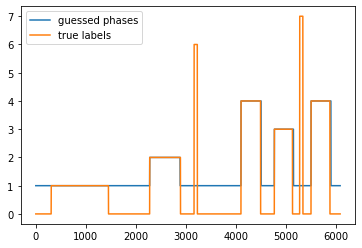

Training: 100%|██████████| 2/2 [03:57<00:00, 118.94s/epoch, loss=(21.99, 16.9)] 


[0.8786166310310364, 0.9366329312324524, 0.5623594522476196, 0.4876638948917389] 0.7666796469366562


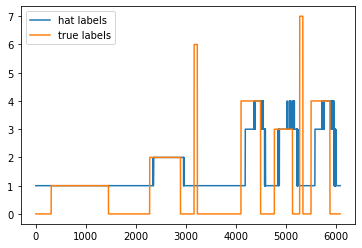


 subject: S3


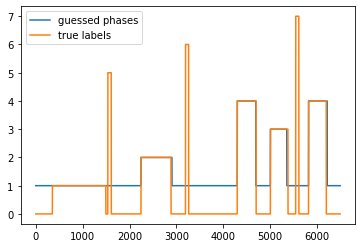

Training: 100%|██████████| 2/2 [04:34<00:00, 137.26s/epoch, loss=(11.25, 9.94)]


[0.8807401061058044, 0.8842692375183105, 0.8280370235443115, 0.8729087114334106] 0.8725564310051107


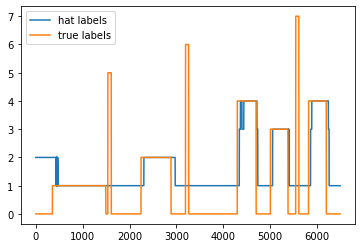


 subject: S4


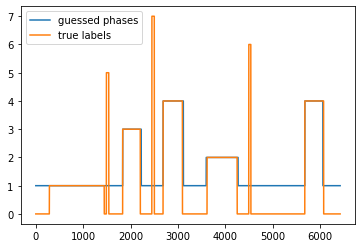

Training: 100%|██████████| 2/2 [04:31<00:00, 135.97s/epoch, loss=(36.74, 24.67)]


[0.5558351278305054, 0.9848501682281494, 0.3107282519340515, 0.854092538356781] 0.6704089309294459


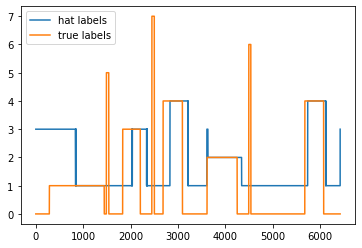


 subject: S5


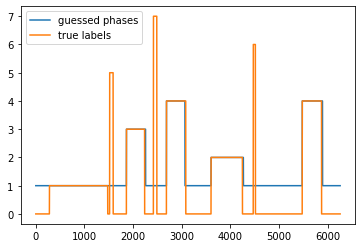

Training: 100%|██████████| 2/2 [04:30<00:00, 135.36s/epoch, loss=(21.77, 10.65)]


[0.8584674596786499, 0.9475562572479248, 0.7436047196388245, 0.9273780584335327] 0.879281803793363


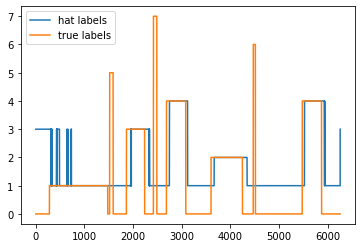


 subject: S6


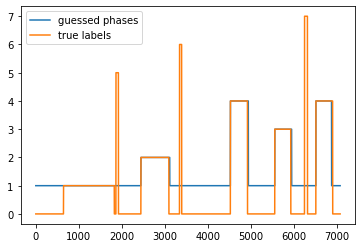

Training: 100%|██████████| 2/2 [05:06<00:00, 153.49s/epoch, loss=(9.19, 11.64)] 


[0.9105597138404846, 0.9509519338607788, 0.934502899646759, 0.9135109782218933] 0.9224447975911676


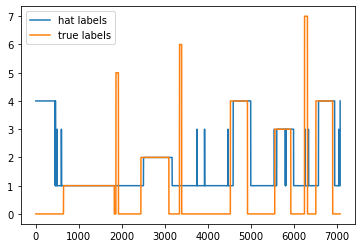


 subject: S7


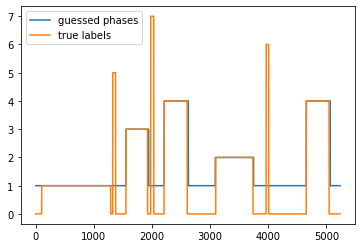

Training: 100%|██████████| 2/2 [03:49<00:00, 114.98s/epoch, loss=(50.05, 17.76)]


[0.9003433585166931, 0.9392642378807068, 0.8611305952072144, 0.9455133080482483] 0.915066516064257


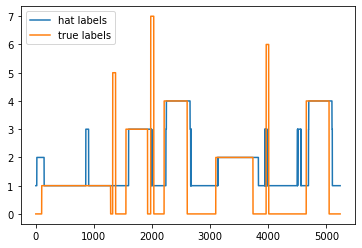


 subject: S8


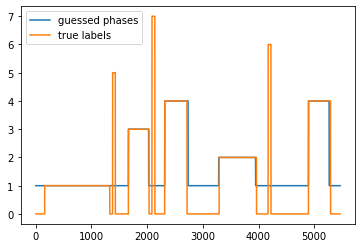

Training: 100%|██████████| 2/2 [04:05<00:00, 122.58s/epoch, loss=(50.21, 20.07)]


[0.7774132490158081, 0.9575533866882324, 0.6246967315673828, 0.9123765826225281] 0.8257383527454243


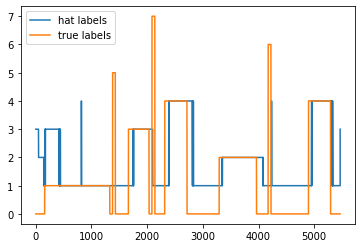


 subject: S9


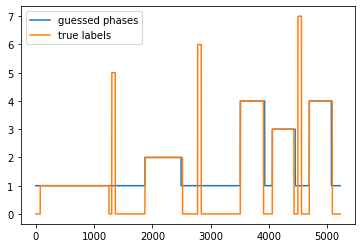

Training: 100%|██████████| 2/2 [03:49<00:00, 114.93s/epoch, loss=(16.61, 32.6)]


[0.9017421007156372, 0.9512062072753906, 0.6331773400306702, 0.8308382630348206] 0.8686350334448161


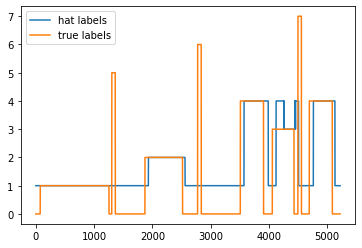


 subject: S10


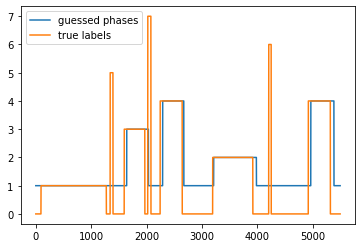

Training: 100%|██████████| 2/2 [04:00<00:00, 120.16s/epoch, loss=(20.43, 19.2)] 


[0.8098865747451782, 0.9475355744361877, 0.6926010847091675, 0.8645285367965698] 0.8384577445811067


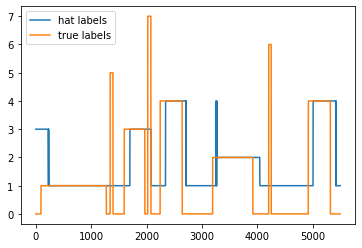


 subject: S11


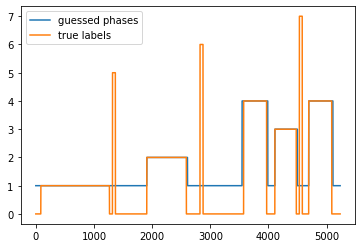

Training: 100%|██████████| 2/2 [03:49<00:00, 114.51s/epoch, loss=(72.13, 32.02)]


[0.9412418603897095, 0.890971839427948, 0.5134641528129578, 0.35926687717437744] 0.7541158386684401


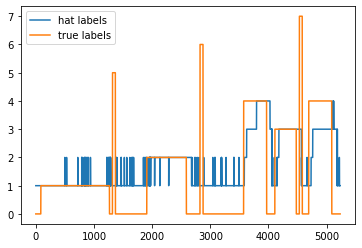


 subject: S13


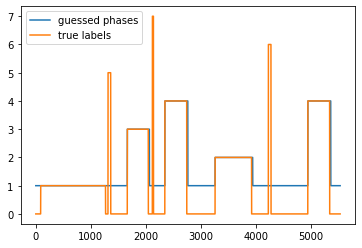

Training: 100%|██████████| 2/2 [04:02<00:00, 121.14s/epoch, loss=(27.74, 12.13)]


[0.8271786570549011, 0.9253354072570801, 0.7347445487976074, 0.9178860187530518] 0.8566093945569083


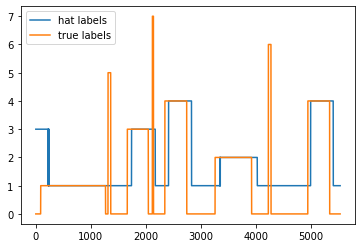


 subject: S14


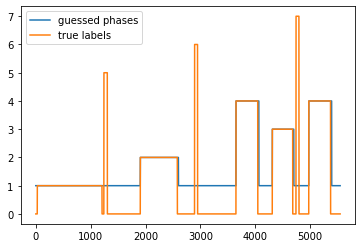

Training: 100%|██████████| 2/2 [04:00<00:00, 120.34s/epoch, loss=(33.33, 12.86)]


[0.9039115309715271, 0.9411375522613525, 0.8582389950752258, 0.8926898837089539] 0.9040466732869911


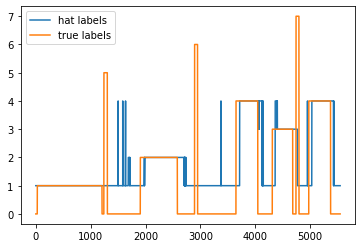


 subject: S15


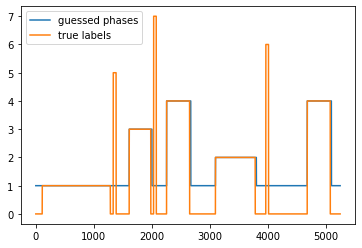

Training: 100%|██████████| 2/2 [03:51<00:00, 115.78s/epoch, loss=(36.99, 11.0)] 


[0.8694208860397339, 0.9511830806732178, 0.8803209662437439, 0.8440005779266357] 0.8825260158572844


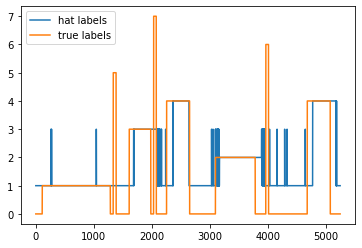


 subject: S16


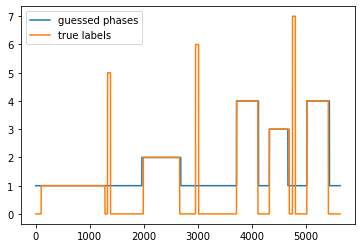

Training: 100%|██████████| 2/2 [04:16<00:00, 128.27s/epoch, loss=(6.21, 12.98)]


[0.8172367811203003, 0.9772527813911438, 0.7993667721748352, 0.8082911372184753] 0.8476557435708618


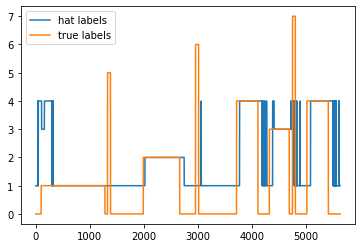


 subject: S17


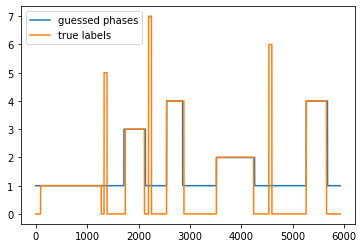

Training: 100%|██████████| 2/2 [04:24<00:00, 132.16s/epoch, loss=(16.58, 14.92)]


[0.8012787699699402, 0.9409987926483154, 0.732344925403595, 0.902131974697113] 0.8443163867642168


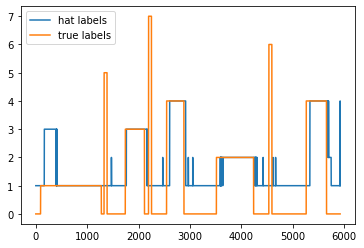

In [19]:
results_dkm = {}
for i in range(NB_CLASSES):
	results_dkm["class " + str(i)] = []
results_dkm["accuracy"] = []

phases_list = ["A", "D", "B", "C"]

for s in subjects:
    print("\n subject:", s)

    # physiological signals
    data = pd.read_pickle(path + s +"/"+ s +".pkl")
    eda = data["signal"]["wrist"]["EDA"].flatten()
    ecg = data["signal"]["wrist"]["BVP"].flatten()
    temp = data["signal"]["wrist"]["TEMP"].flatten()
    
    labels_true = data["label"]
    time_labels = np.arange(0, labels_true.size, 1) * (1/LABEL_RATE) + INIT_TIME

    signal, time = preprocessing(eda, ecg, temp, cardio_sampling_rate=CARDIO_SAMPLING_RATE, bvp=True, init_time=INIT_TIME)

    # seeding

    score_s = score[score["subject"] == s]
    # there is a little shift beween time labels and the actual start
    start_base_questionnaire = score_s[score_s["phase"] == "A"]["start"].values
    start_base_label = time_labels[np.argmax(labels_true == 1)]
    time_shift = start_base_questionnaire -start_base_label

    s_init = init_membership(score_s=score_s, time=time, nb_classes=NB_CLASSES, time_shift=time_shift, default=0, one_hot=False)
    
    plt.plot(time, s_init, label="guessed phases")
    plt.plot(time_labels, labels_true, label="true labels")
    plt.legend(loc="upper left")
    plt.show()


    deepkmeans = DeepKMeans(signal, time)
    labels_hat, time_hat = deepkmeans.run(nb_classes=NB_CLASSES, seq_len=SEQ_LEN, s_init=s_init, epochs_pre=1, epochs_train=2, batch_size=128, 
            embedding=30, lr_pretrain=5e-5, lr_train=5e-5,  pre_train_cluster=False)
    

    labels_true_down = resampling_labels(labels_true, labels_hat, time_labels, time_hat)

    list_acc, over_all_accuracy = accuracy(labels_true=labels_true_down, labels_hat=labels_hat, classes=list(range(1, NB_CLASSES+1)))
    for i in range(NB_CLASSES):
        results_dkm["class " + str(i)].append(list_acc[i])
    results_dkm["accuracy"].append(over_all_accuracy)
    print(list_acc, over_all_accuracy)

    plt.plot(time_hat, labels_hat, label="hat labels")
    plt.plot(time_labels, labels_true, label="true labels")
    plt.legend(loc="upper left")
    plt.show()

In [20]:
results_dkm = pd.DataFrame(results_dkm, index=subjects)
print(results_dkm)
print(results_dkm.describe().round(2))

      class 0   class 1   class 2   class 3  accuracy
S2   0.878617  0.936633  0.562359  0.487664  0.766680
S3   0.880740  0.884269  0.828037  0.872909  0.872556
S4   0.555835  0.984850  0.310728  0.854093  0.670409
S5   0.858467  0.947556  0.743605  0.927378  0.879282
S6   0.910560  0.950952  0.934503  0.913511  0.922445
S7   0.900343  0.939264  0.861131  0.945513  0.915067
S8   0.777413  0.957553  0.624697  0.912377  0.825738
S9   0.901742  0.951206  0.633177  0.830838  0.868635
S10  0.809887  0.947536  0.692601  0.864529  0.838458
S11  0.941242  0.890972  0.513464  0.359267  0.754116
S13  0.827179  0.925335  0.734745  0.917886  0.856609
S14  0.903912  0.941138  0.858239  0.892690  0.904047
S15  0.869421  0.951183  0.880321  0.844001  0.882526
S16  0.817237  0.977253  0.799367  0.808291  0.847656
S17  0.801279  0.940999  0.732345  0.902132  0.844316
       class 0  class 1  class 2  class 3  accuracy
count    15.00    15.00    15.00    15.00     15.00
mean      0.84     0.94     0.71

In [21]:
print(results_dkm.describe())

         class 0    class 1    class 2    class 3   accuracy
count  15.000000  15.000000  15.000000  15.000000  15.000000
mean    0.842258   0.941780   0.713955   0.822205   0.843236
std     0.092119   0.026570   0.165070   0.168098   0.067443
min     0.555835   0.884269   0.310728   0.359267   0.670409
25%     0.813562   0.937949   0.628937   0.837419   0.832098
50%     0.869421   0.947536   0.734745   0.872909   0.856609
75%     0.901043   0.951195   0.843138   0.912944   0.880904
max     0.941242   0.984850   0.934503   0.945513   0.922445


Clustering with deep k-means. The pre-training minimises the clustering loss.


 subject: S2


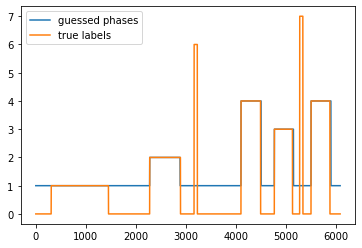

Training: 100%|██████████| 2/2 [04:26<00:00, 133.14s/epoch, loss=(58.67, 70.34)]


[0.8660106062889099, 0.9107815027236938, 0.8814213871955872, 0.8701728582382202] 0.877466251298027


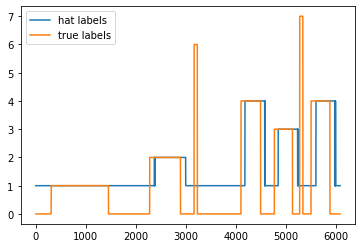


 subject: S3


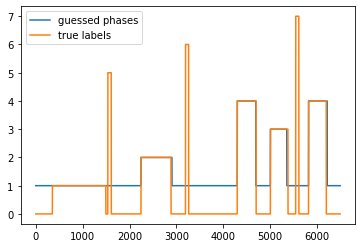

Training: 100%|██████████| 2/2 [04:46<00:00, 143.22s/epoch, loss=(17.5, 44.01)] 


[0.8773449063301086, 0.9130088686943054, 0.896348774433136, 0.8968443274497986] 0.891396933560477


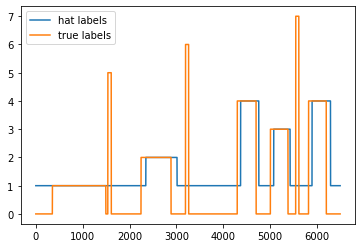


 subject: S4


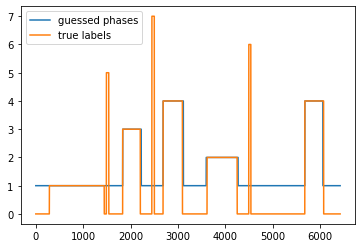

Training: 100%|██████████| 2/2 [04:38<00:00, 139.14s/epoch, loss=(38.95, 43.98)] 


[0.887671172618866, 0.9733225703239441, 0.8604111075401306, 0.8827203512191772] 0.9013104939473172


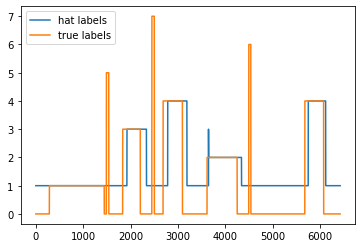


 subject: S5


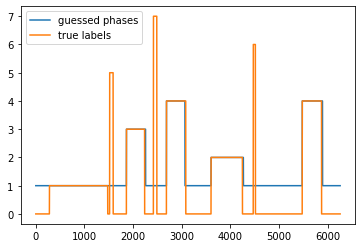

Training: 100%|██████████| 2/2 [04:35<00:00, 137.75s/epoch, loss=(20.58, 20.48)] 


[0.806333065032959, 0.9308607578277588, 0.6541467308998108, 0.7672302722930908] 0.8088736670039698


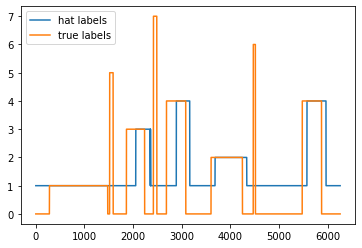


 subject: S6


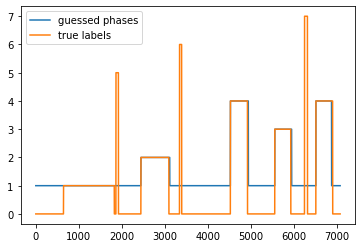

Training: 100%|██████████| 2/2 [05:12<00:00, 156.06s/epoch, loss=(34.48, 41.56)] 


[0.8964064121246338, 0.9309622645378113, 0.8968073725700378, 0.9180736541748047] 0.9087539729006356


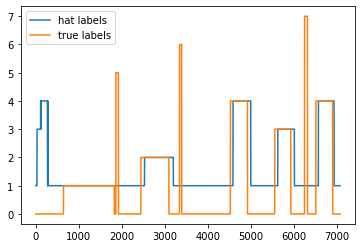


 subject: S7


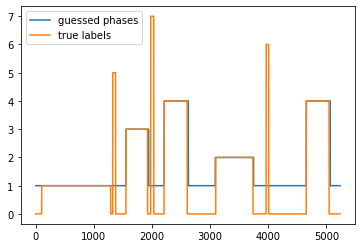

Training: 100%|██████████| 2/2 [03:47<00:00, 113.80s/epoch, loss=(26.41, 54.01)]


[0.902061939239502, 0.9460954666137695, 0.8645825982093811, 0.9300263524055481] 0.9138114959839357


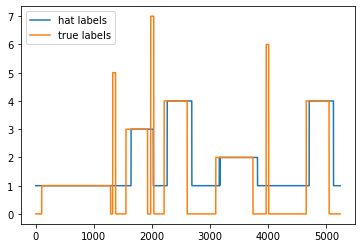


 subject: S8


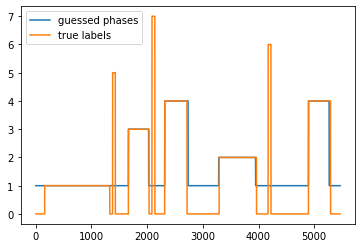

Training: 100%|██████████| 2/2 [03:57<00:00, 118.98s/epoch, loss=(27.85, 51.09)]


[0.8848885297775269, 0.9449727535247803, 0.8476605415344238, 0.906276524066925] 0.8987884775374376


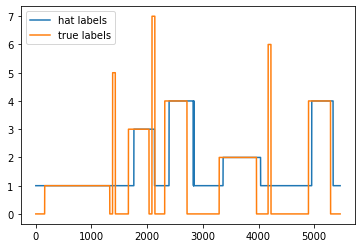


 subject: S9


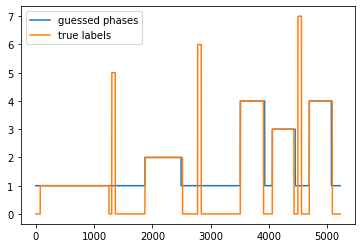

Training: 100%|██████████| 2/2 [03:45<00:00, 112.73s/epoch, loss=(17.11, 88.45)] 


[0.8854911923408508, 0.9373559951782227, 0.8861494064331055, 0.8931585550308228] 0.897930602006689


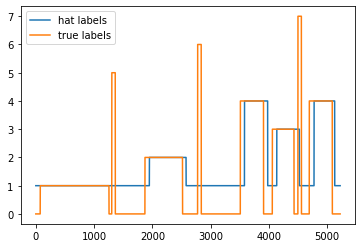


 subject: S10


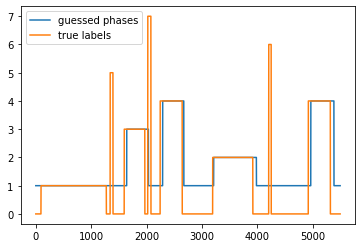

Training: 100%|██████████| 2/2 [04:00<00:00, 120.43s/epoch, loss=(28.64, 47.86)]


[0.8500739932060242, 0.9435818195343018, 0.7913493514060974, 0.8477466702461243] 0.8645518195176766


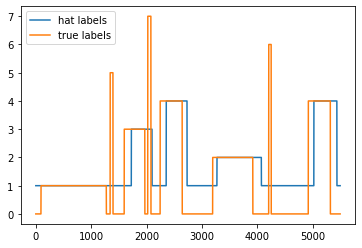


 subject: S11


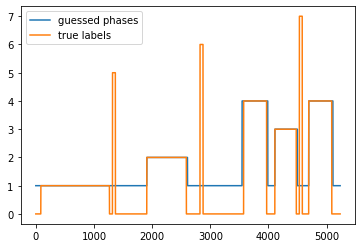

Training: 100%|██████████| 2/2 [04:07<00:00, 123.60s/epoch, loss=(74.57, 80.79)]  


[0.8348413705825806, 0.864670991897583, 0.8559492826461792, 0.8451632857322693] 0.8453500468385287


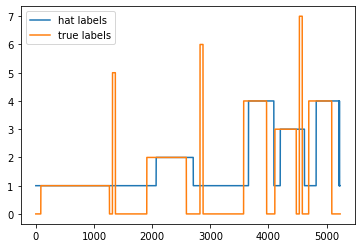


 subject: S13


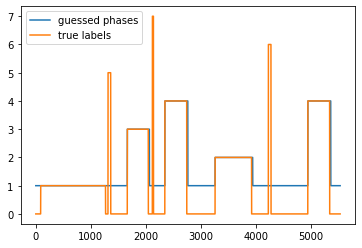

Training: 100%|██████████| 2/2 [04:05<00:00, 122.50s/epoch, loss=(47.77, 43.87)]


[0.8031495809555054, 0.9196939468383789, 0.6791992783546448, 0.8858744502067566] 0.8303559421968906


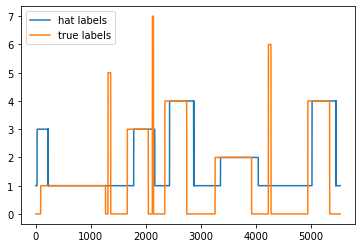


 subject: S14


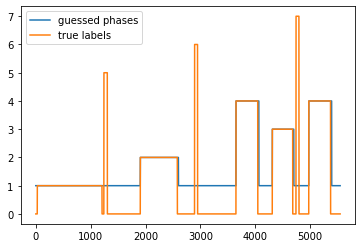

Training: 100%|██████████| 2/2 [04:12<00:00, 126.13s/epoch, loss=(51.04, 74.47)]


[0.8312649130821228, 0.9013923406600952, 0.8101949095726013, 0.8226680755615234] 0.8414277143330023


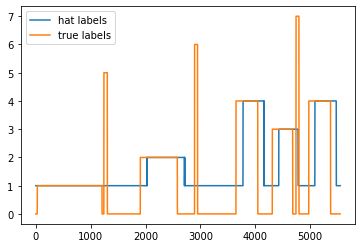


 subject: S15


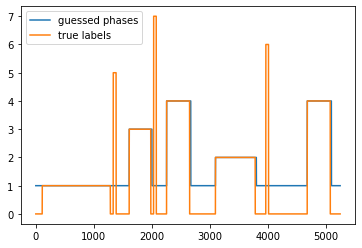

Training: 100%|██████████| 2/2 [03:50<00:00, 115.33s/epoch, loss=(48.72, 70.93)] 


[0.8570044636726379, 0.9265131950378418, 0.8709096312522888, 0.8449859023094177] 0.8704627106045589


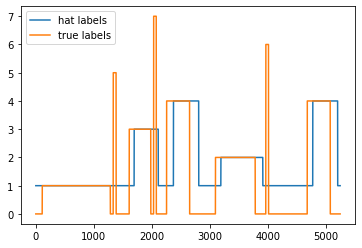


 subject: S16


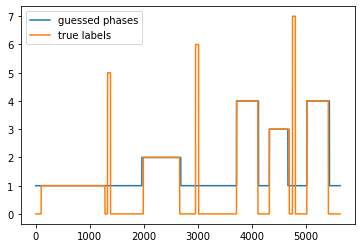

Training: 100%|██████████| 2/2 [04:07<00:00, 123.63s/epoch, loss=(6.51, 46.99)]


[0.9242499470710754, 0.9818942546844482, 0.9365362524986267, 0.9139061570167542] 0.9358045562740818


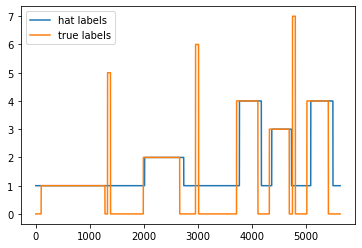


 subject: S17


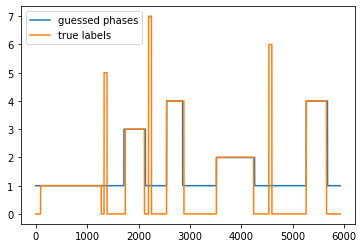

Training: 100%|██████████| 2/2 [04:22<00:00, 131.01s/epoch, loss=(30.98, 63.75)]


[0.7332786321640015, 0.936715841293335, 0.917941153049469, 0.7100139856338501] 0.7940326737612238


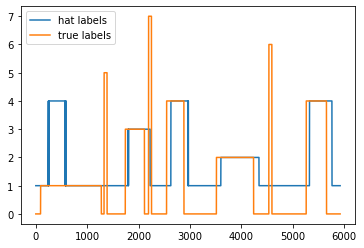

In [22]:
results_dkm_c = {}
for i in range(NB_CLASSES):
	results_dkm_c["class " + str(i)] = []
results_dkm_c["accuracy"] = []

phases_list = ["A", "D", "B", "C"]

for s in subjects:
    print("\n subject:", s)

    # physiological signals
    data = pd.read_pickle(path + s +"/"+ s +".pkl")
    eda = data["signal"]["wrist"]["EDA"].flatten()
    ecg = data["signal"]["wrist"]["BVP"].flatten()
    temp = data["signal"]["wrist"]["TEMP"].flatten()
    
    labels_true = data["label"]
    time_labels = np.arange(0, labels_true.size, 1) * (1/LABEL_RATE) + INIT_TIME

    signal, time = preprocessing(eda, ecg, temp, cardio_sampling_rate=CARDIO_SAMPLING_RATE, bvp=True, init_time=INIT_TIME)

    # seeding

    score_s = score[score["subject"] == s]
    # there is a little shift beween time labels and the actual start
    start_base_questionnaire = score_s[score_s["phase"] == "A"]["start"].values
    start_base_label = time_labels[np.argmax(labels_true == 1)]
    time_shift = start_base_questionnaire -start_base_label

    s_init = init_membership(score_s=score_s, time=time, nb_classes=NB_CLASSES, time_shift=time_shift, default=0, one_hot=False)
    
    plt.plot(time, s_init, label="guessed phases")
    plt.plot(time_labels, labels_true, label="true labels")
    plt.legend(loc="upper left")
    plt.show()


    deepkmeans = DeepKMeans(signal, time)
    labels_hat, time_hat = deepkmeans.run(nb_classes=NB_CLASSES, seq_len=SEQ_LEN, s_init=s_init, epochs_pre=1, epochs_train=2, batch_size=128, 
            embedding=30, lr_pretrain=5e-5, lr_train=5e-5,  pre_train_cluster=True)
    

    labels_true_down = resampling_labels(labels_true, labels_hat, time_labels, time_hat)

    list_acc, over_all_accuracy = accuracy(labels_true=labels_true_down, labels_hat=labels_hat, classes=list(range(1, NB_CLASSES+1)))
    for i in range(NB_CLASSES):
        results_dkm_c["class " + str(i)].append(list_acc[i])
    results_dkm_c["accuracy"].append(over_all_accuracy)
    print(list_acc, over_all_accuracy)

    plt.plot(time_hat, labels_hat, label="hat labels")
    plt.plot(time_labels, labels_true, label="true labels")
    plt.legend(loc="upper left")
    plt.show()

In [23]:
results_dkm_c = pd.DataFrame(results_dkm_c, index=subjects)
print(results_dkm_c)
print(results_dkm_c.describe().round(2))

      class 0   class 1   class 2   class 3  accuracy
S2   0.866011  0.910782  0.881421  0.870173  0.877466
S3   0.877345  0.913009  0.896349  0.896844  0.891397
S4   0.887671  0.973323  0.860411  0.882720  0.901310
S5   0.806333  0.930861  0.654147  0.767230  0.808874
S6   0.896406  0.930962  0.896807  0.918074  0.908754
S7   0.902062  0.946095  0.864583  0.930026  0.913811
S8   0.884889  0.944973  0.847661  0.906277  0.898788
S9   0.885491  0.937356  0.886149  0.893159  0.897931
S10  0.850074  0.943582  0.791349  0.847747  0.864552
S11  0.834841  0.864671  0.855949  0.845163  0.845350
S13  0.803150  0.919694  0.679199  0.885874  0.830356
S14  0.831265  0.901392  0.810195  0.822668  0.841428
S15  0.857004  0.926513  0.870910  0.844986  0.870463
S16  0.924250  0.981894  0.936536  0.913906  0.935805
S17  0.733279  0.936716  0.917941  0.710014  0.794033
       class 0  class 1  class 2  class 3  accuracy
count    15.00    15.00    15.00    15.00     15.00
mean      0.86     0.93     0.84

In [24]:
print(results_dkm_c.describe())

         class 0    class 1    class 2    class 3   accuracy
count  15.000000  15.000000  15.000000  15.000000  15.000000
mean    0.856005   0.930788   0.843307   0.862324   0.872021
std     0.048618   0.028274   0.080809   0.059809   0.040819
min     0.733279   0.864671   0.654147   0.710014   0.794033
25%     0.833053   0.916351   0.828928   0.845075   0.843389
50%     0.866011   0.930962   0.864583   0.882720   0.877466
75%     0.886581   0.944277   0.891249   0.901560   0.900049
max     0.924250   0.981894   0.936536   0.930026   0.935805
